In [2]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

from lmfit import Model

import scipy.special
import math

from astropy.io import fits

import random

from astropy.time import Time

import os

from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clip

In [3]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

plt.rc('font', family='serif', size=11)
plt.tight_layout()

<Figure size 900x600 with 0 Axes>

In [4]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [5]:
def highpass(flux, order, sigma):
    highpass_lst = []
    highpass_lst.append(flux)
    
    for i in range(0, order):
        lowpass = gaussian_filter(highpass_lst[i], sigma=sigma)
        highpass = highpass_lst[i] - lowpass
        highpass_lst.append(highpass)

    return highpass_lst

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


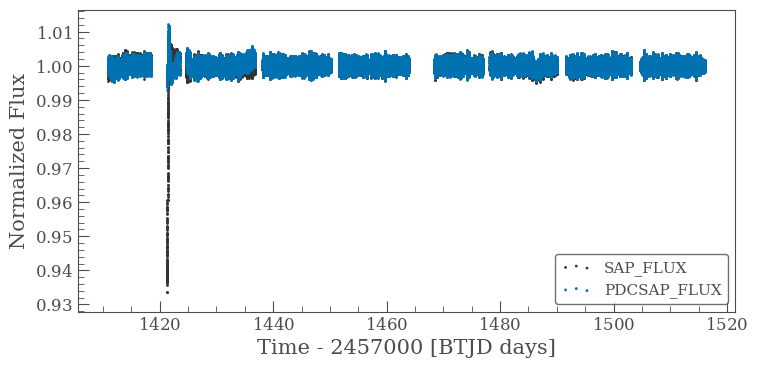

In [6]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [10]:
len(times) * np.median(np.diff(times))/(max(times)-min(times))

0.8531263017155057

In [8]:
()/np.median(np.diff(times))

120.00003308057785

In [7]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

In [8]:
print('Calculate AS')
#AS
freq, amp = AS(times, mags, 15)

freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.02, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))


print('Calculate Phases')
# PHASES
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)



# SELECT HOW MANY FREQS FOR COMPARISON

n = 20

f_TESS = f_TESS[:20]
a_TESS = a_TESS[:20]
p_TESS = p_TESS[:20]

Calculate AS


82
Calculate Phases


In [13]:
f_TESS

array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 , 48.91898731, 43.52777037, 47.28565013, 57.45201737,
       34.76022934, 38.12894767, 45.26948964, 53.85766147, 51.49607267,
       50.71711598, 47.13987304, 47.66403674, 49.71252171, 44.68384605])

## BRITE

In [21]:
datadir = os.getcwd()
datadir_BRITE = '/BRITE'
datafileB15 = '/betaPic_2015_BHr.dat'
datafileB16 = '/betaPic_2016_BTrBHr.dat'
datafileB17 = '/betaPic_2017_BHr.dat'

tB15, mB15 = np.loadtxt(datadir + datadir_BRITE + datafileB15, usecols=(0, 1)).T
tB16, mB16 = np.loadtxt(datadir + datadir_BRITE + datafileB16, usecols=(0, 1)).T
tB17, mB17 = np.loadtxt(datadir + datadir_BRITE + datafileB17, usecols=(0, 1)).T

mB15 = mB15/1000
mB16 = mB16/1000
mB17 = mB17/1000

In [22]:
datadir = os.getcwd()
datafileB15 = '/times2015.txt.bjd'
datafileB16 = '/times2016.txt.bjd'
datafileB17 = '/times2017.txt.bjd'

tB15_BJD = np.loadtxt(datadir + datafileB15, usecols=(0)).T
tB16_BJD = np.loadtxt(datadir + datafileB16, usecols=(0)).T
tB17_BJD = np.loadtxt(datadir + datafileB17, usecols=(0)).T

In [222]:
def DC(times):
    t = max(times)-min(times)
    ray = 1/t*1000
    cad = np.median(np.diff(times))*86400 
    fNy = 0.5 / cad * 86400
    dc = len(times) * np.median(np.diff(times))/(max(times)-min(times))*100
    return ('%s' % float('%.4g' % t), '%s' % float('%.4g' % ray), '%s' % float('%.4g' % fNy), '%s' % float('%.4g' % cad), '%s' % float('%.3g' % dc))

In [24]:
DC(times)

('105.2', '9.507', '360.0', '120.0', '85.3')

In [25]:
DC(tB15_BJD)

('78.32', '12.77', '4167.0', '10.37', '6.78')

In [26]:
DC(tB16_BJD)

('224.6', '4.453', '2128.0', '20.3', '7.07')

In [27]:
DC(tB17_BJD)

('167.3', '5.976', '2128.0', '20.3', '7.48')

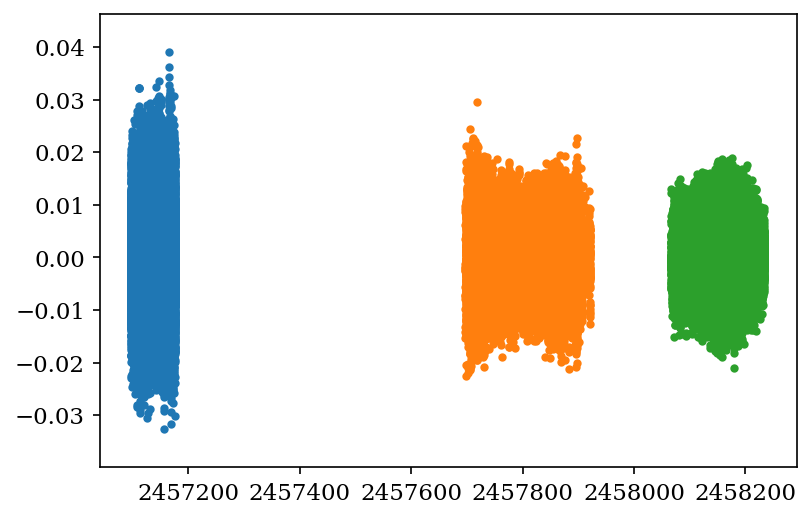

In [28]:
plt.scatter(tB15_BJD, mB15, marker='.')
plt.scatter(tB16_BJD, mB16, marker='.')
plt.scatter(tB17_BJD, mB17, marker='.')

(0, 0.0006)

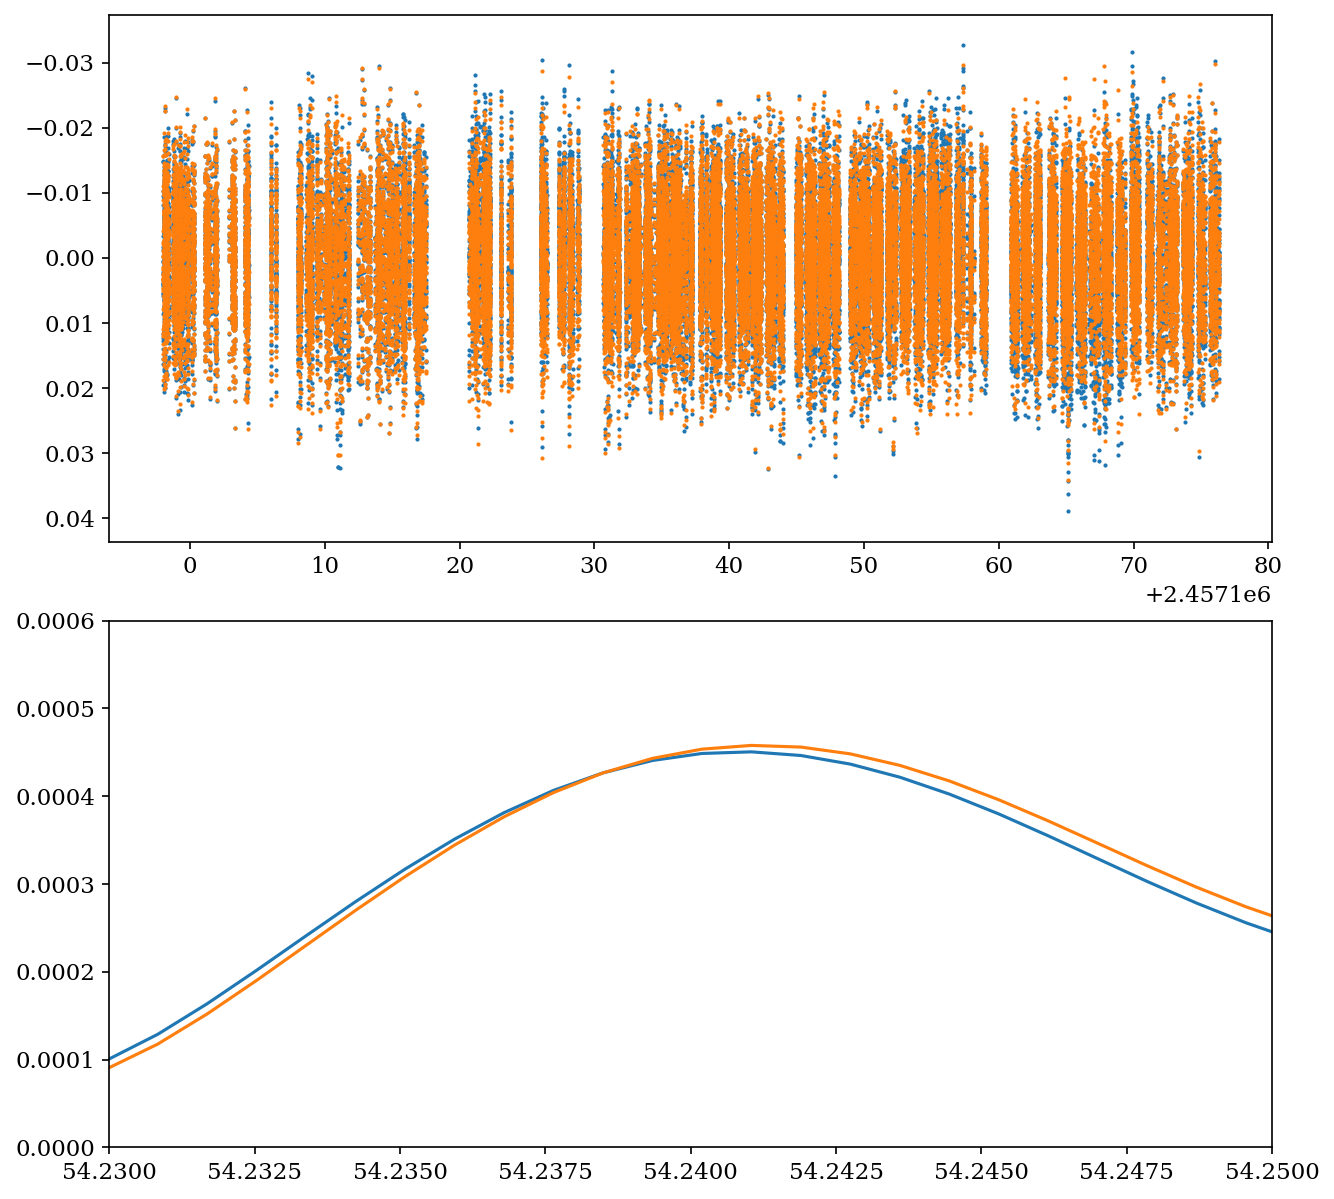

In [29]:
highpass_own = highpass(mB15, 5, 250)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(tB15_BJD, highpass_own[0], s=1, label='{0}'.format(0), alpha=1, c='C0')
ax[0].scatter(tB15_BJD, highpass_own[hpmax], s=1, label='{0}'.format(5), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(tB15_BJD, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(tB15_BJD, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
mB15_gaus = highpass_own[hpmax]

plt.xlim(54.23,54.25)
plt.ylim(0,0.0006)

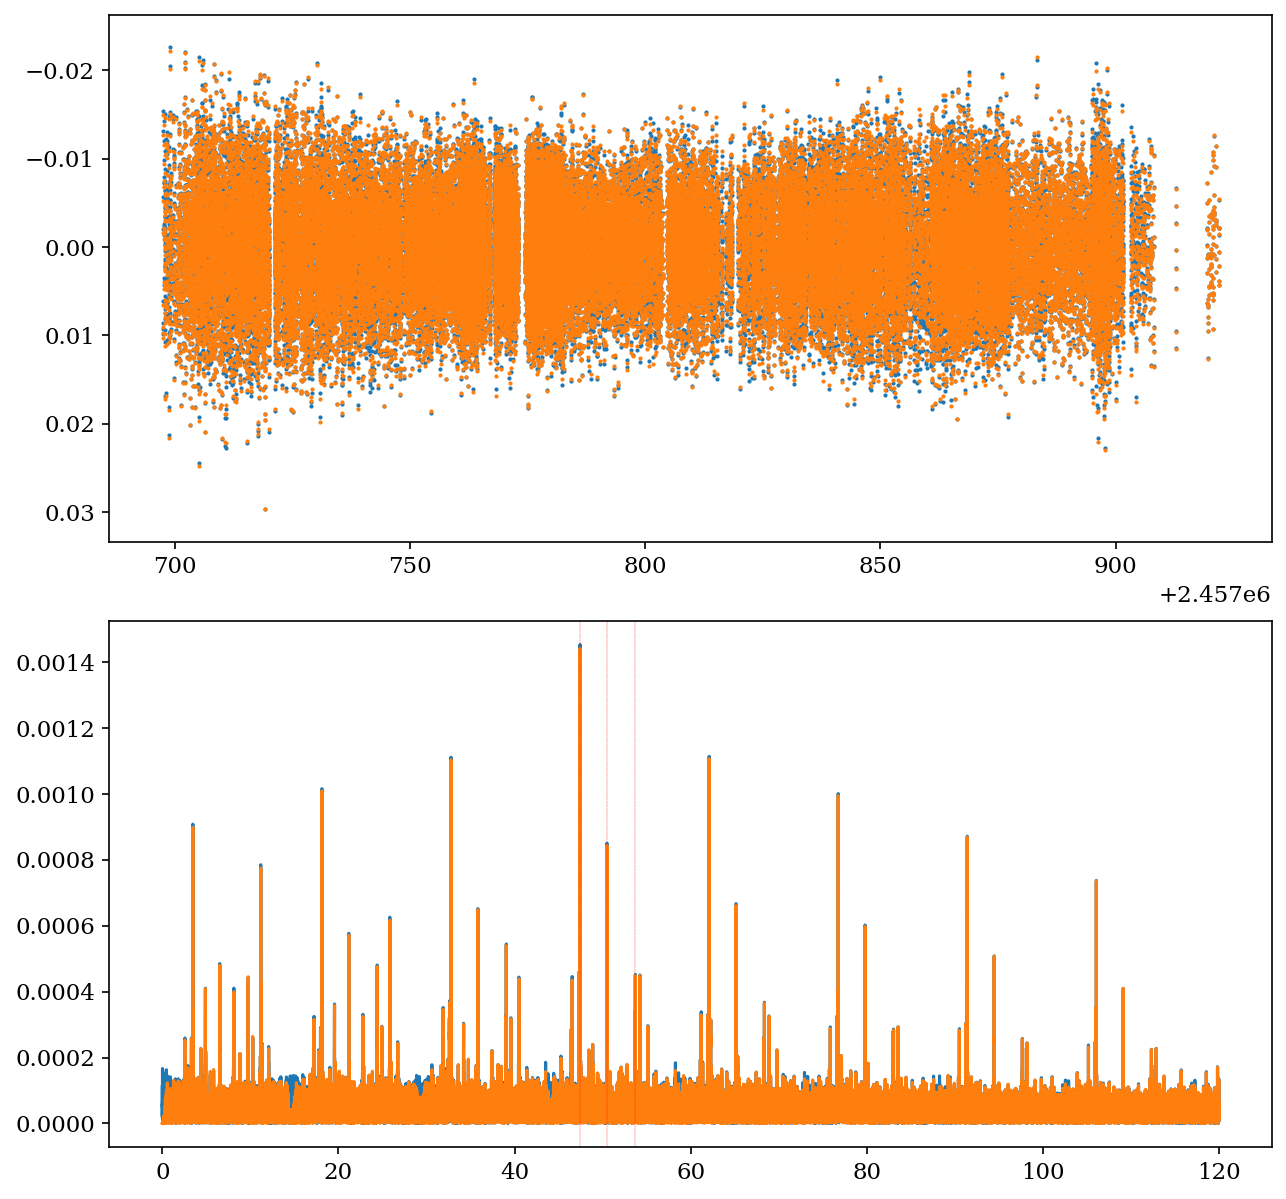

In [30]:
highpass_own = highpass(mB16, 5, 250)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(tB16_BJD, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(tB16_BJD, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(tB16_BJD, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(tB16_BJD, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
mB16_gaus = highpass_own[hpmax]

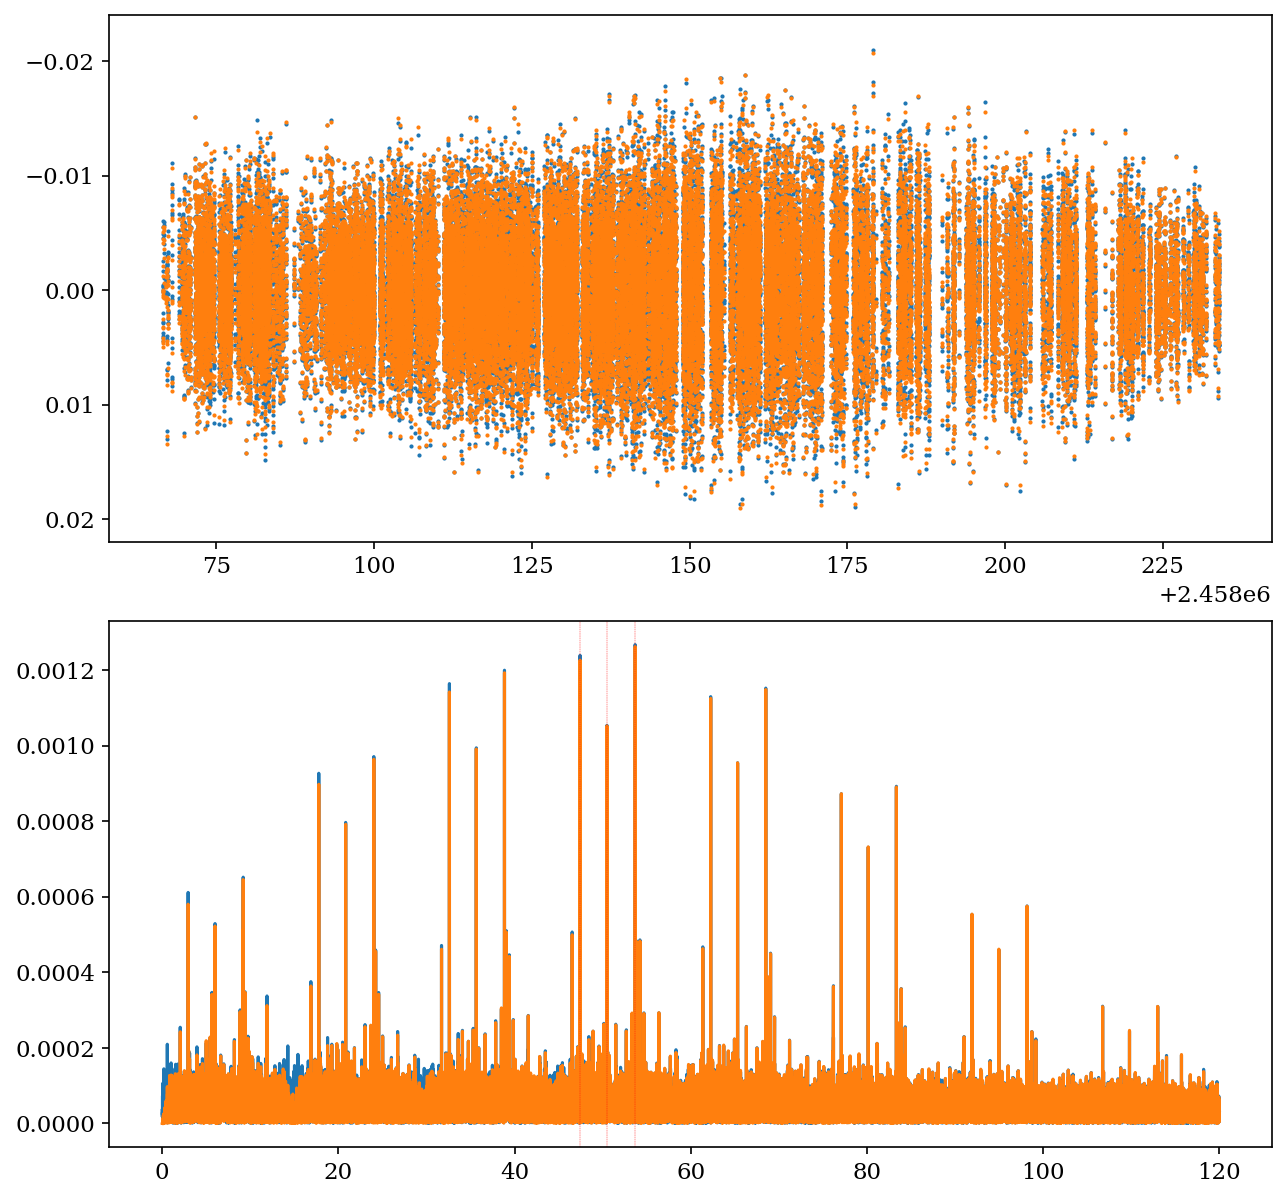

In [31]:
highpass_own = highpass(mB17, 5, 250)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(tB17_BJD, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(tB17_BJD, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(tB17_BJD, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(tB17_BJD, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
mB17_gaus = highpass_own[hpmax]

#plt.xlim(54.23,54.25)

In [32]:
mB17

array([-0.004533, -0.001679, -0.000252, ...,  0.004781, -0.002396,
       -0.002876])

In [156]:
np.savetxt('BRITE15.txt', np.array([tB15_BJD, mB15_gaus]).T)
np.savetxt('BRITE16.txt', np.array([tB16_BJD, mB16_gaus]).T)
np.savetxt('BRITE17.txt', np.array([tB17_BJD, mB17_gaus]).T)

In [288]:
np.savetxt('BRITE15_nogaus.txt', np.array([tB15_BJD, mB15]).T)
np.savetxt('BRITE16_nogaus.txt', np.array([tB16_BJD, mB16]).T)
np.savetxt('BRITE17_nogaus.txt', np.array([tB17_BJD, mB17]).T)

# bRing

In [33]:
datadir = os.getcwd()
datadir_bRing = '/bRing'
datafile_bRing = '/Reduced_2110269.fits'

In [34]:
fits_image_filename = datadir+datadir_bRing+datafile_bRing
hdul = fits.open(fits_image_filename)
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                42360 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'jd      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'raw     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'reduced '        

In [35]:
databring = fits.getdata(datadir+datadir_bRing+datafile_bRing)
bsel = np.where(np.isfinite(databring['reduced']))[0]
jd = databring['jd'][bsel]
raw = databring['raw'][bsel]
reduced = databring['reduced'][bsel]
reducedHF = databring['reducedHF'][bsel]

In [36]:
clip1 = sigma_clip(reduced, sigma=5, cenfunc=np.median, iters=1)
mags_clip1 = clip1[~clip1.mask].data
times_clip1 = jd[~clip1.mask]

clipN = sigma_clip(reduced, sigma=4, cenfunc=np.median, iters=None)
mags_clipN = clipN[~clipN.mask].data
times_clipN = jd[~clipN.mask]

In [37]:
t_bRing = times_clip1
m_bRing = mags_clip1

In [38]:
DC(t_bRing)

('575.5', '1.738', '135.4', '319.1', '27.0')

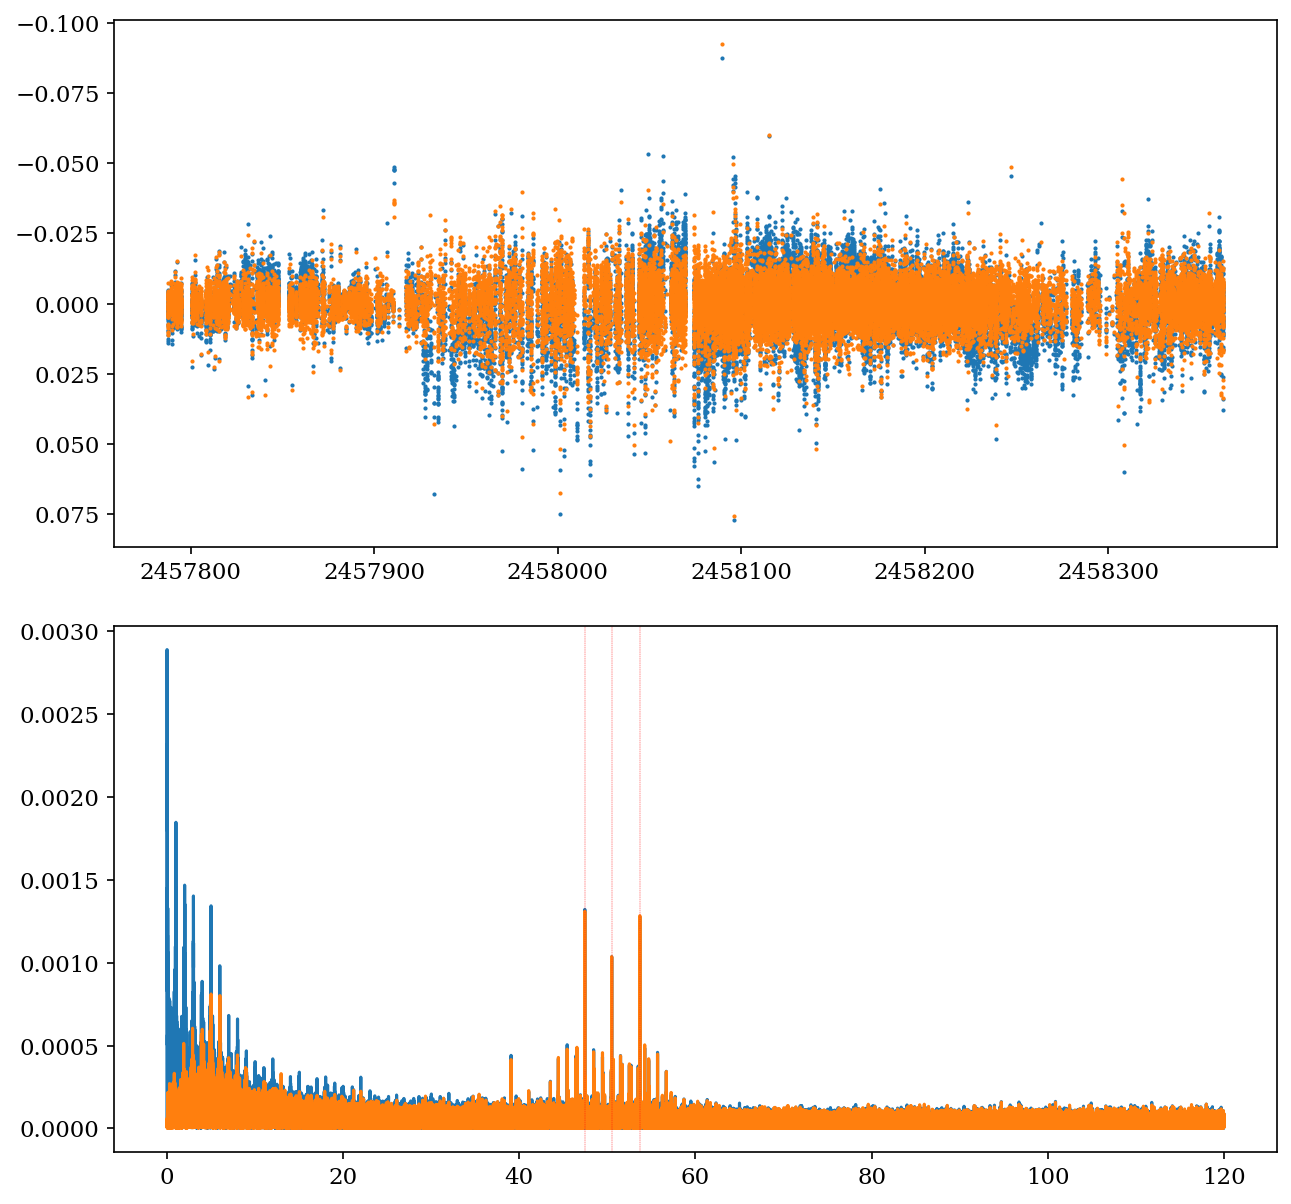

In [39]:
highpass_own = highpass(m_bRing, 5, 30)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(t_bRing, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(t_bRing, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(t_bRing, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(t_bRing, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
m_bRing_gaus = highpass_own[hpmax]

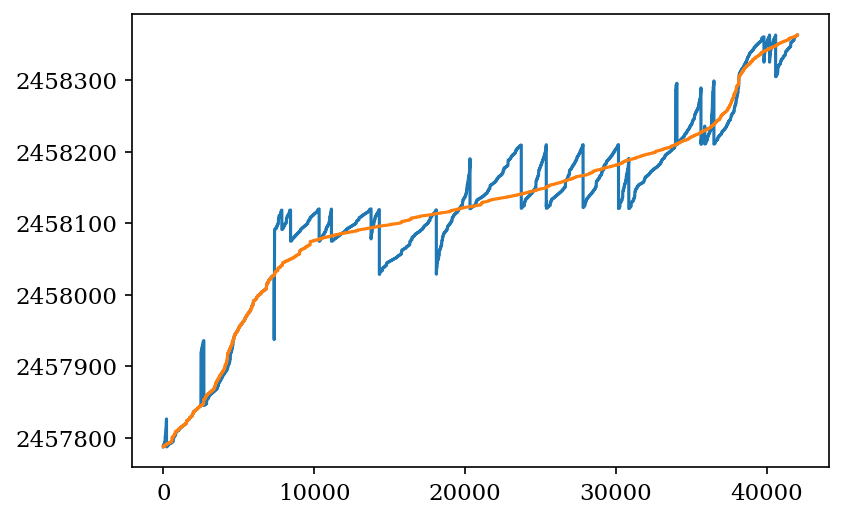

In [48]:
plt.plot(range(len(t_bRing)), t_bRing)

sort_idx_bRing = np.argsort(t_bRing)

plt.plot(range(len(t_bRing)), t_bRing[sort_idx_bRing])

In [164]:
np.savetxt('bRing.txt', np.array([t_bRing[sort_idx_bRing], m_bRing_gaus[sort_idx_bRing]]).T)

In [50]:
bRing_len = len(t_bRing[sort_idx_bRing])

In [33]:
plt.scatter(t_bRing[sort_idx_bRing], m_bRing_gaus[sort_idx_bRing], s=1)
plt.ylim(0.1, -0.1)

NameError: name 'm_bRing_gaus' is not defined

In [34]:
t_bRing[sort_idx_bRing][:bRing_len//2]

array([2457787.31215396, 2457787.31215399, 2457787.31584746, ...,
       2458125.20610148, 2458125.20986253, 2458125.21337652])

In [35]:
DC(t_bRing[sort_idx_bRing][:bRing_len//2])

(318.6696454882622, 22.933125307242456)

In [36]:
DC(t_bRing[sort_idx_bRing][bRing_len//2:])

(319.11591142416, 32.661217930610846)

(0.1, -0.1)

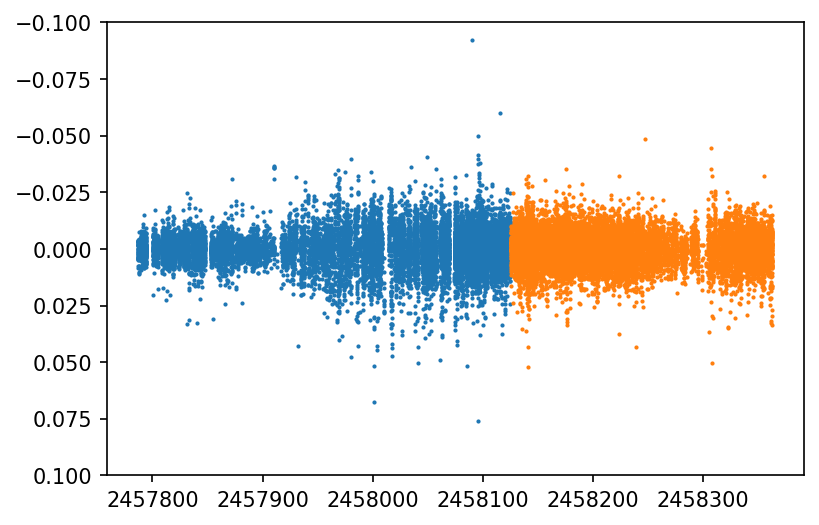

In [168]:
plt.scatter(t_bRing[sort_idx_bRing][:bRing_len//2], m_bRing_gaus[sort_idx_bRing][:bRing_len//2], s=1)
plt.scatter(t_bRing[sort_idx_bRing][bRing_len//2:], m_bRing_gaus[sort_idx_bRing][bRing_len//2:], s=1)
plt.ylim(0.1, -0.1)

In [169]:
np.savetxt('bRing1.txt', np.array([t_bRing[sort_idx_bRing][:bRing_len//2], m_bRing_gaus[sort_idx_bRing][:bRing_len//2]]).T)
np.savetxt('bRing2.txt', np.array([t_bRing[sort_idx_bRing][bRing_len//2:], m_bRing_gaus[sort_idx_bRing][bRing_len//2:]]).T)

# ASTEP

In [40]:
datadir = os.getcwd() 
datadir_ASTEP = '/ASTEP'

astep17 = np.recfromcsv(datadir+datadir_ASTEP+'/bjd_bp_flux_2017.csv')
astep18 = np.recfromcsv(datadir+datadir_ASTEP+'/bjd_bp_flux_2018.csv')

In [41]:
astep17flux = (astep17['flux1']-4*astep17['fsky1'])/(astep17['flux3']-4*astep17['fsky3'])
astep18flux = (astep18['flux1']-4*astep18['fsky1'])/(astep18['flux3']-4*astep18['fsky3'])
astep17nflux = astep17flux/np.nanmedian(astep17flux)
astep18nflux = astep18flux/np.nanmedian(astep18flux)
a17sel = np.where(np.isfinite(astep17nflux) & (astep17['sunelev'] < -18) & (astep17['xs1'] == 2048) & (astep17['ys1'] == 2048))[0]
a18sel = np.where(np.isfinite(astep18nflux) & (astep18['sunelev'] < -18) & (astep18['xs1'] == 2048) & (astep18['ys1'] == 2048))[0]

In [39]:
# t_ASTEP = np.concatenate((astep17['bjd'][a17sel]+2400000, astep18['bjd'][a18sel]+2400000), axis=None)
# m_ASTEP = np.concatenate((astep17nflux[a17sel], astep18nflux[a18sel]), axis=None)

In [42]:
t_ASTEP17 = astep17['bjd'][a17sel]+2400000
t_ASTEP18 = astep18['bjd'][a18sel]+2400000
m_ASTEP17 = astep17nflux[a17sel]
m_ASTEP18 = astep18nflux[a18sel]

In [43]:
clip1 = sigma_clip(m_ASTEP17, sigma=5, cenfunc=np.median, iters=1)
mags_clip1 = clip1[~clip1.mask].data
times_clip1 = (t_ASTEP17)[~clip1.mask]

t_ASTEP17 = times_clip1
m_ASTEP17 = -2.5*np.log10(mags_clip1)

clip1 = sigma_clip(m_ASTEP18, sigma=5, cenfunc=np.median, iters=1)
mags_clip1 = clip1[~clip1.mask].data
times_clip1 = (t_ASTEP18)[~clip1.mask]

t_ASTEP18 = times_clip1
m_ASTEP18 = -2.5*np.log10(mags_clip1)

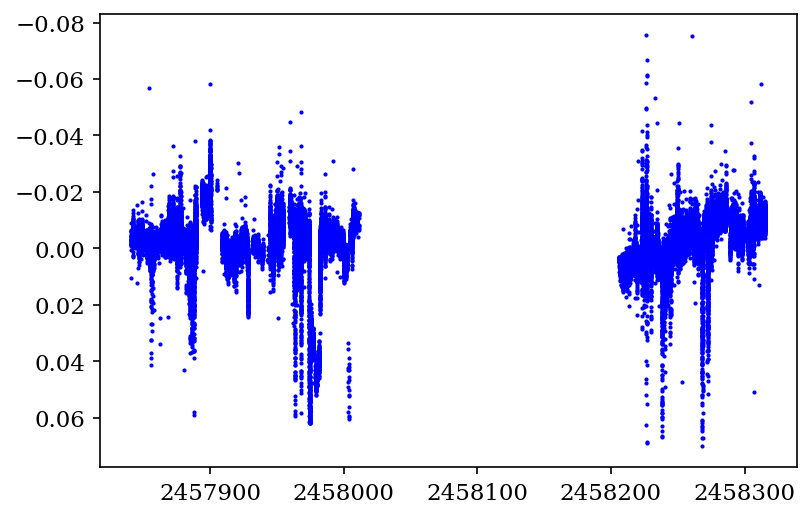

In [44]:
plt.scatter(t_ASTEP17,m_ASTEP17,c='b',label='ASTEP', s=1)
plt.scatter(t_ASTEP18,m_ASTEP18,c='b', s=1)
plt.gca().invert_yaxis()
#plt.ylim(0,2)

In [80]:
DC(t_ASTEP17)

('170.0', '5.881', '495.8', '87.13', '18.9')

In [81]:
DC(t_ASTEP18)

('109.3', '9.15', '502.9', '85.91', '29.2')

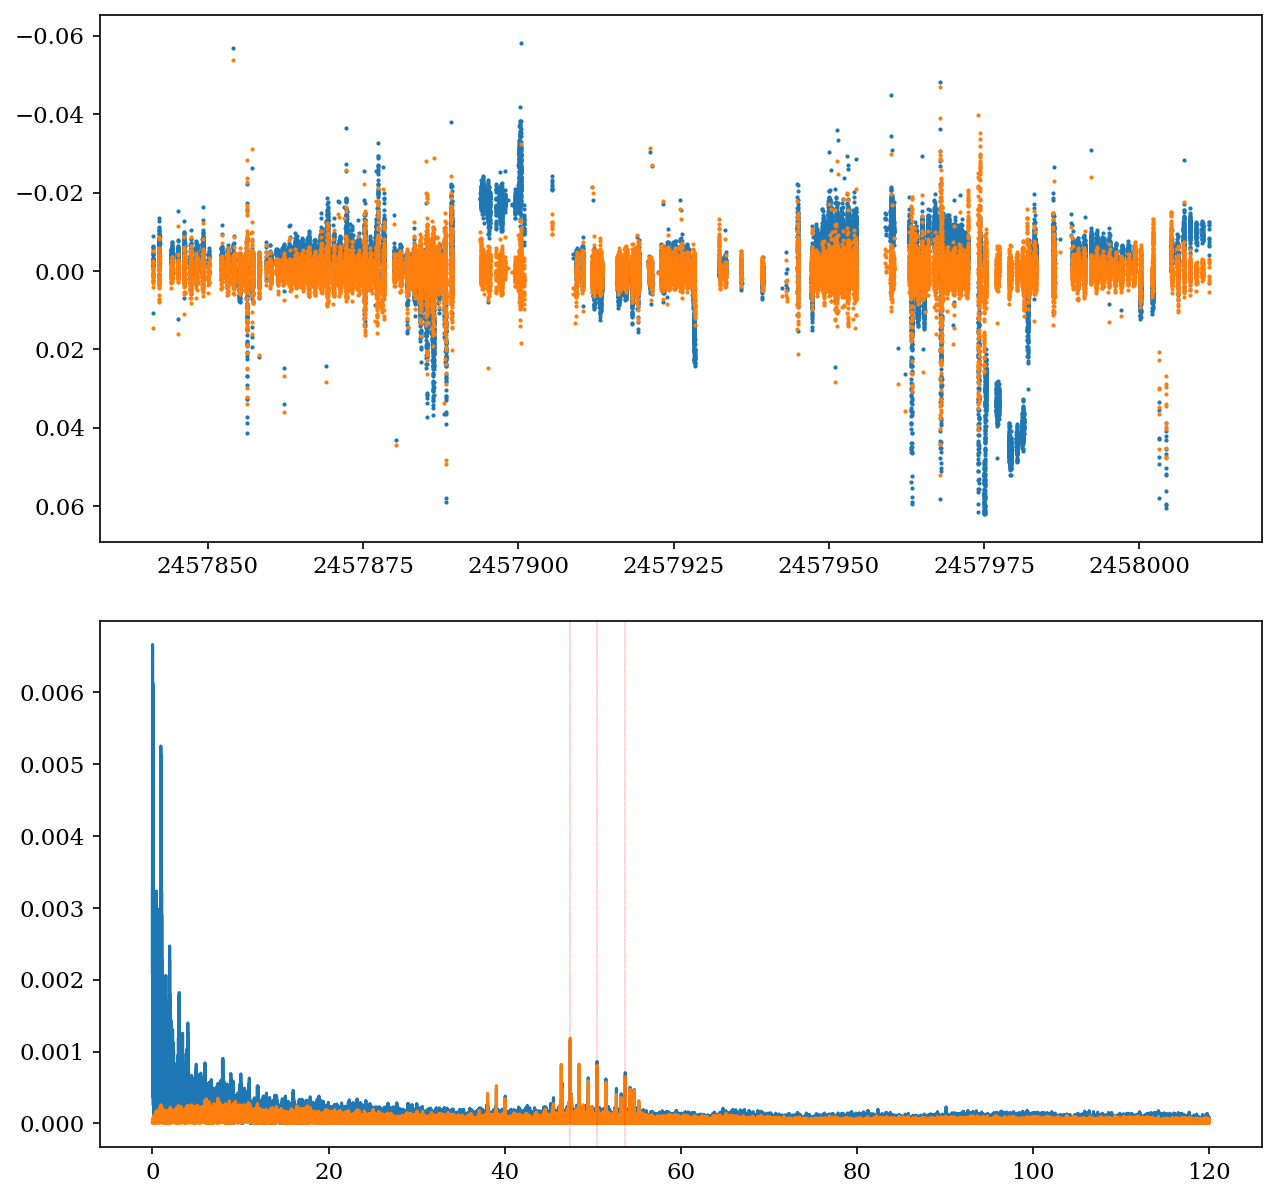

In [45]:
highpass_own = highpass(m_ASTEP17, 5, 50)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(t_ASTEP17, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(t_ASTEP17, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(t_ASTEP17, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(t_ASTEP17, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
m_ASTEP17_gaus = highpass_own[hpmax]

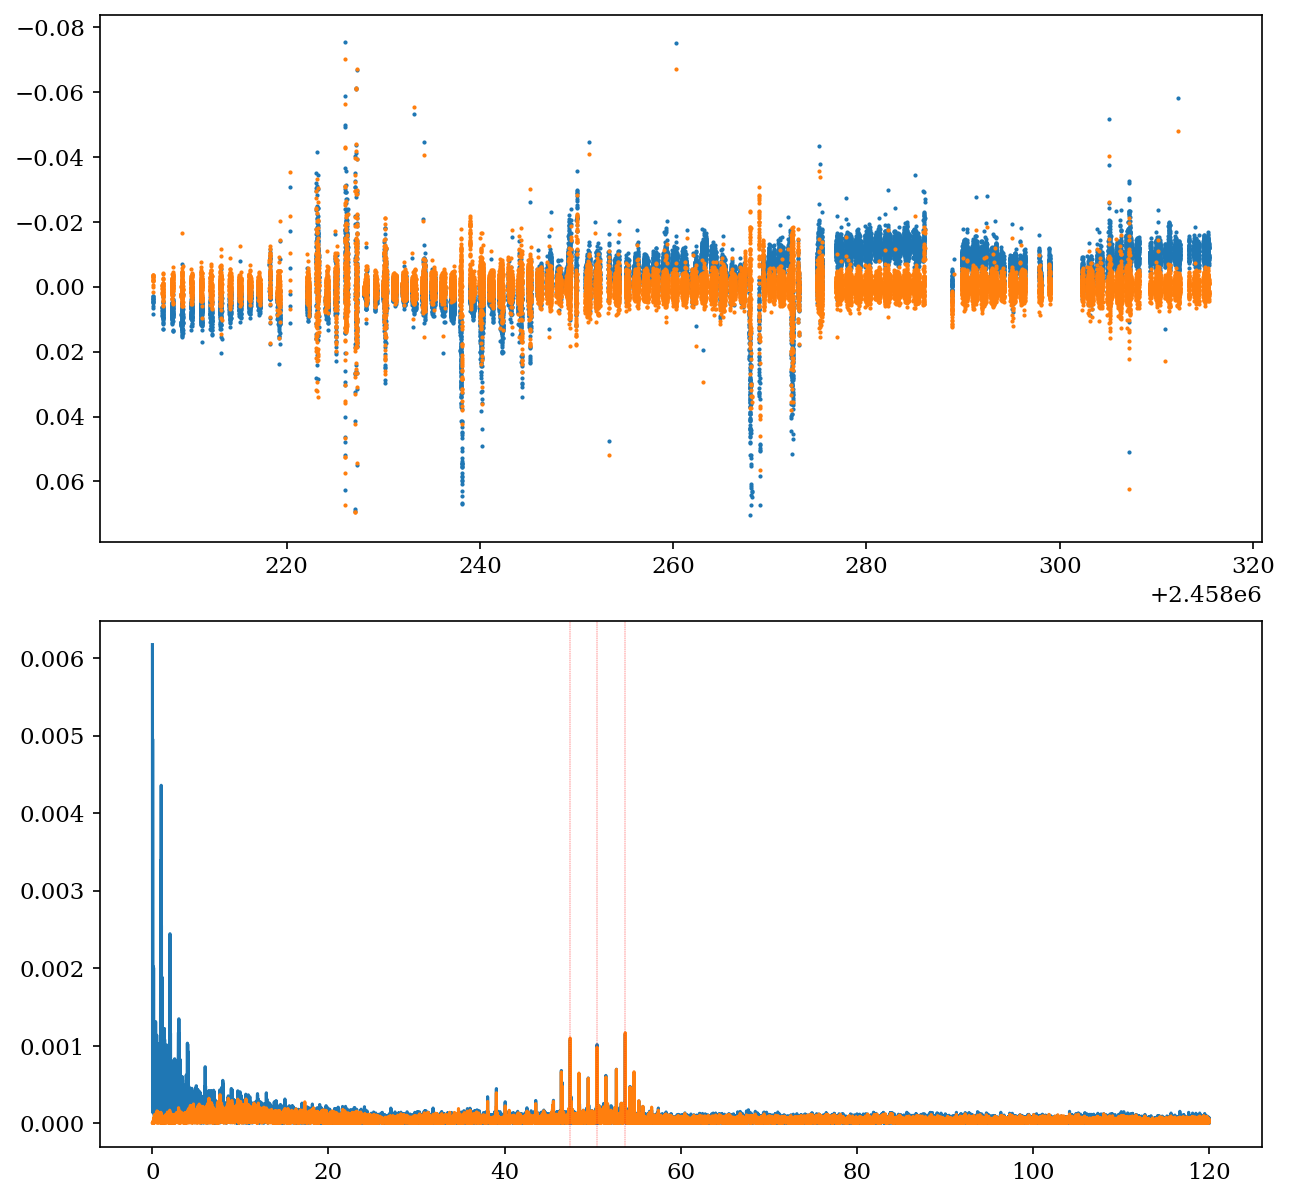

In [46]:
highpass_own = highpass(m_ASTEP18, 5, 50)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(t_ASTEP18, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(t_ASTEP18, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(t_ASTEP18, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(t_ASTEP18, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
m_ASTEP18_gaus = highpass_own[hpmax]

In [178]:
np.savetxt('ASTEP17_2048.txt', np.array([t_ASTEP17, m_ASTEP17_gaus]).T)
np.savetxt('ASTEP18_2048.txt', np.array([t_ASTEP18, m_ASTEP18_gaus]).T)

# ASTEP all

In [179]:
datadir = os.getcwd() 
datadir_ASTEP = '/ASTEP'

astep17 = np.recfromcsv(datadir+datadir_ASTEP+'/bjd_bp_flux_2017.csv')
astep18 = np.recfromcsv(datadir+datadir_ASTEP+'/bjd_bp_flux_2018.csv')

In [180]:
astep17flux = (astep17['flux1']-4*astep17['fsky1'])/(astep17['flux3']-4*astep17['fsky3'])
astep18flux = (astep18['flux1']-4*astep18['fsky1'])/(astep18['flux3']-4*astep18['fsky3'])
astep17nflux = astep17flux/np.nanmedian(astep17flux)
astep18nflux = astep18flux/np.nanmedian(astep18flux)
a17sel = np.where(np.isfinite(astep17nflux) & (astep17['sunelev'] < -18))[0]
a18sel = np.where(np.isfinite(astep18nflux) & (astep18['sunelev'] < -18))[0]

In [181]:
# t_ASTEP = np.concatenate((astep17['bjd'][a17sel]+2400000, astep18['bjd'][a18sel]+2400000), axis=None)
# m_ASTEP = np.concatenate((astep17nflux[a17sel], astep18nflux[a18sel]), axis=None)

In [182]:
t_ASTEP17 = astep17['bjd'][a17sel]+2400000
t_ASTEP18 = astep18['bjd'][a18sel]+2400000
m_ASTEP17 = astep17nflux[a17sel]
m_ASTEP18 = astep18nflux[a18sel]

In [183]:
clip1 = sigma_clip(m_ASTEP17, sigma=5, cenfunc=np.median, iters=300)
mags_clip1 = clip1[~clip1.mask].data
times_clip1 = (t_ASTEP17)[~clip1.mask]

t_ASTEP17 = times_clip1
m_ASTEP17 = -2.5*np.log10(mags_clip1)

clip1 = sigma_clip(m_ASTEP18, sigma=5, cenfunc=np.median, iters=300)
mags_clip1 = clip1[~clip1.mask].data
times_clip1 = (t_ASTEP18)[~clip1.mask]

t_ASTEP18 = times_clip1
m_ASTEP18 = -2.5*np.log10(mags_clip1)

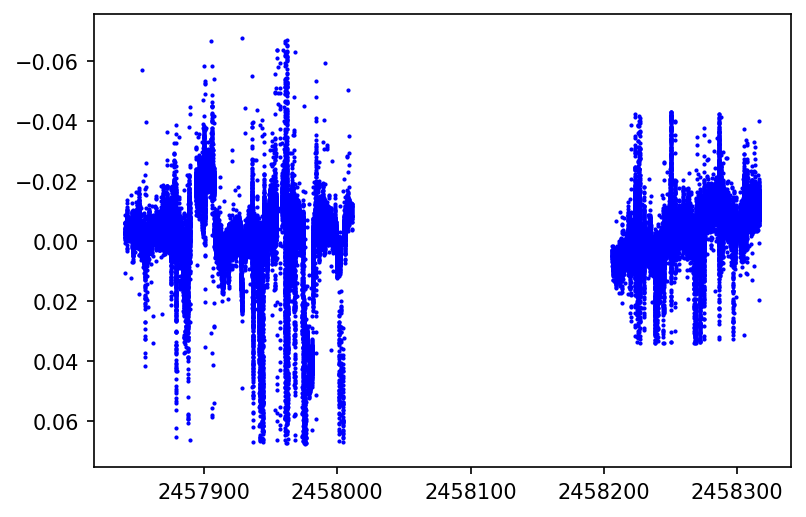

In [184]:
plt.scatter(t_ASTEP17,m_ASTEP17,c='b',label='ASTEP', s=1)
plt.scatter(t_ASTEP18,m_ASTEP18,c='b', s=1)
plt.gca().invert_yaxis()
#plt.ylim(0,2)

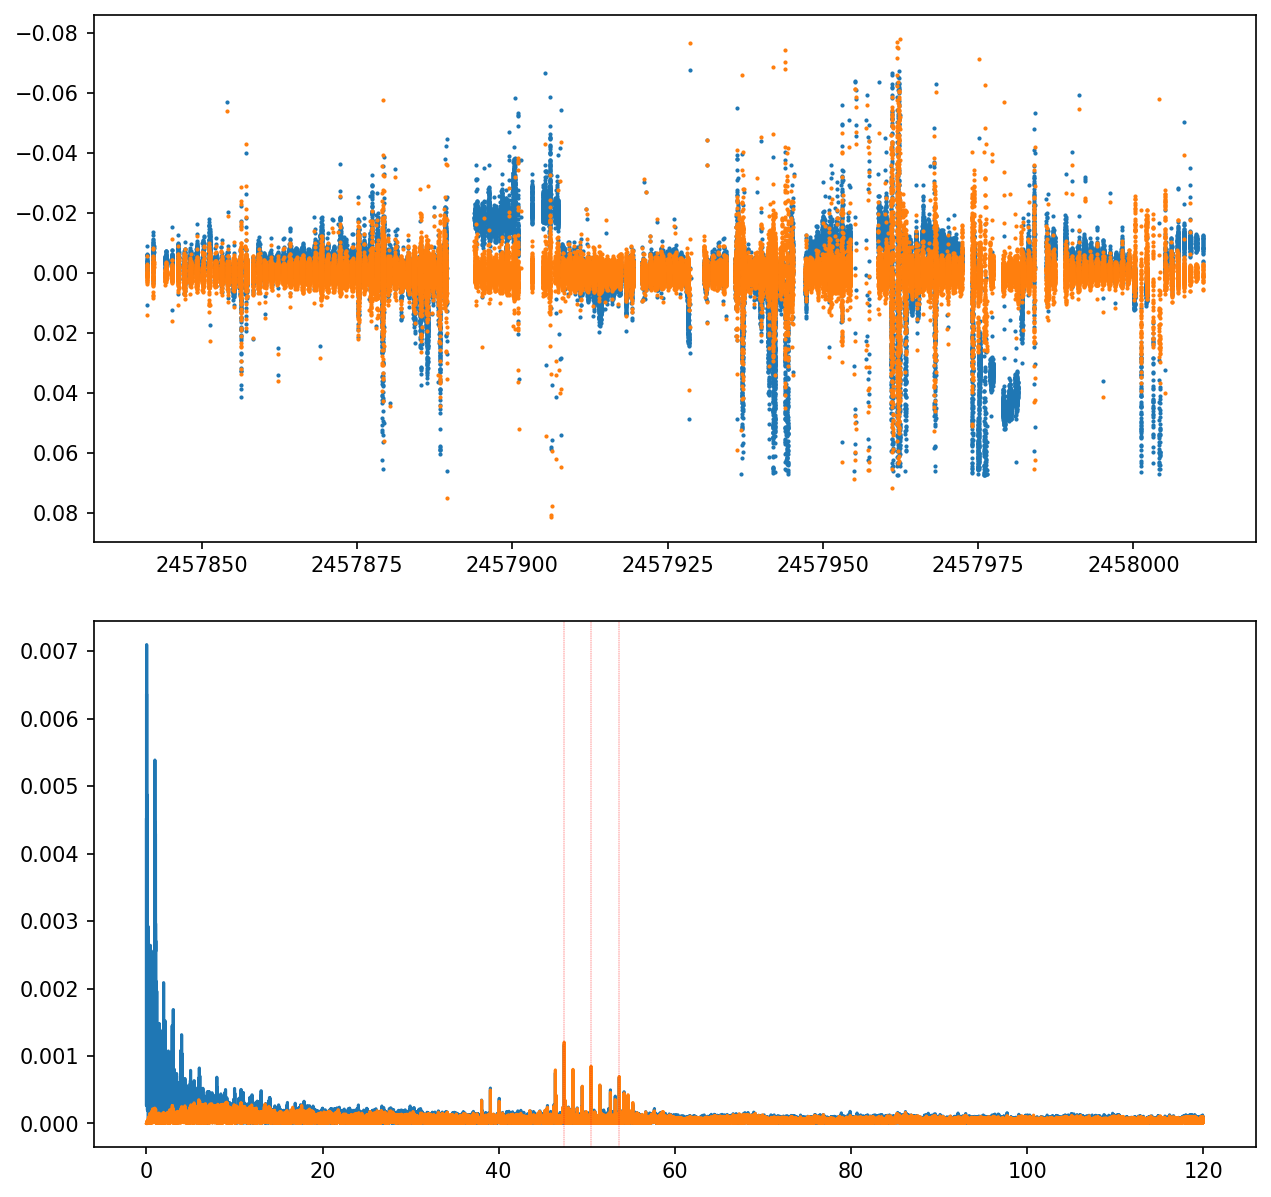

In [185]:
highpass_own = highpass(m_ASTEP17, 5, 50)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(t_ASTEP17, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(t_ASTEP17, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(t_ASTEP17, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(t_ASTEP17, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
m_ASTEP17_gaus = highpass_own[hpmax]

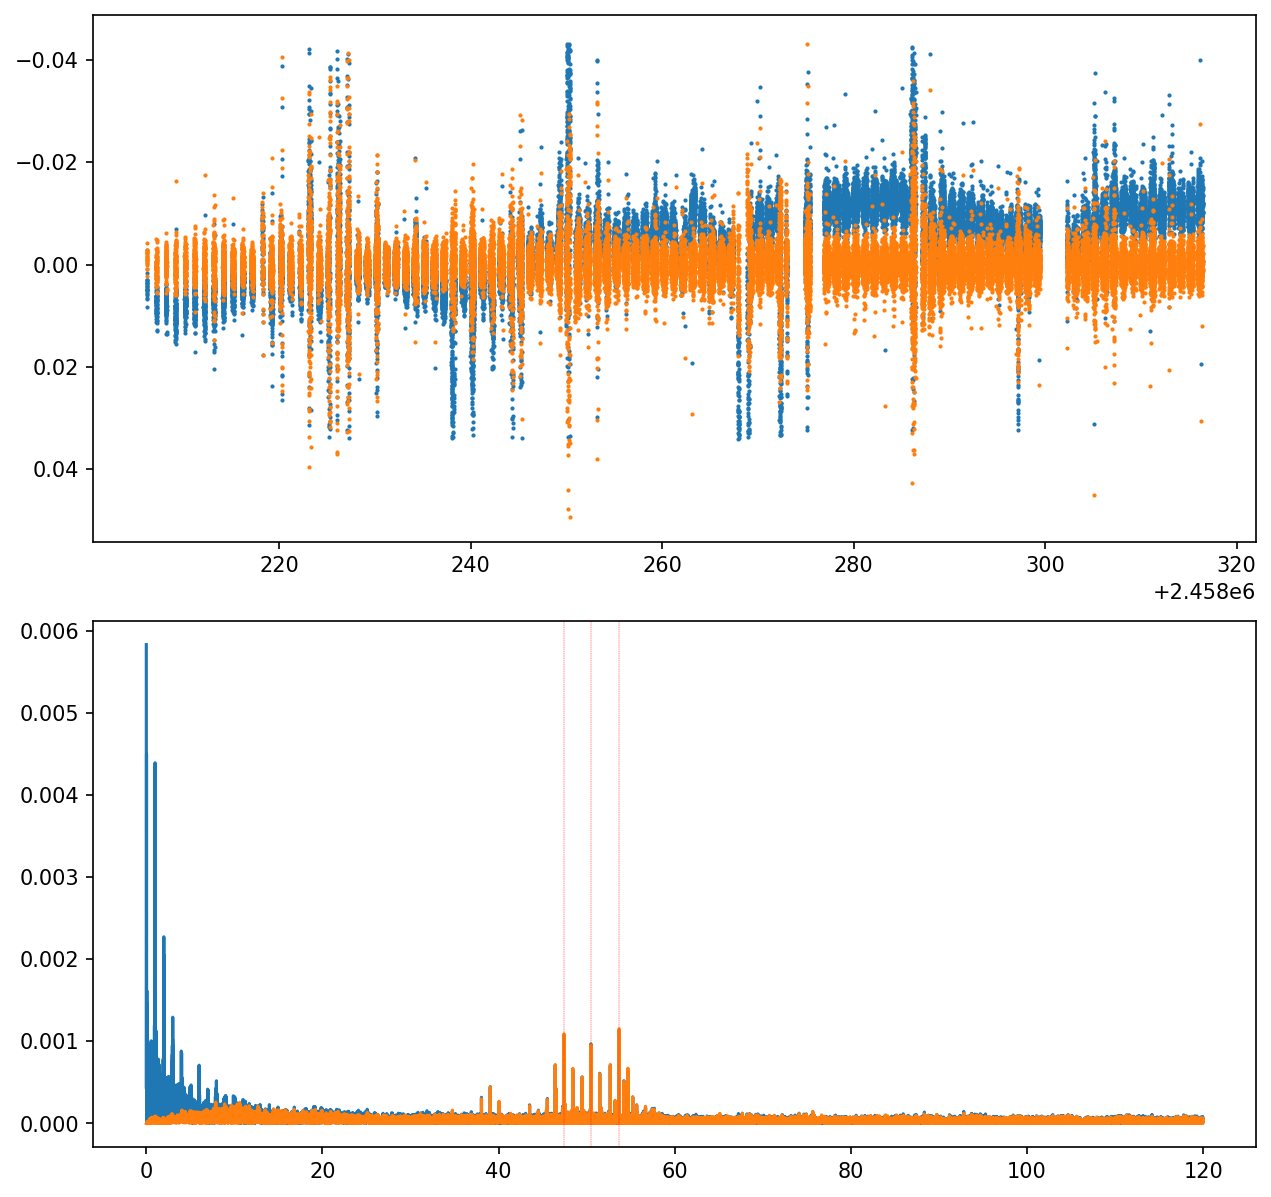

In [186]:
highpass_own = highpass(m_ASTEP18, 5, 50)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(t_ASTEP18, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(t_ASTEP18, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(t_ASTEP18, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(t_ASTEP18, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
m_ASTEP18_gaus = highpass_own[hpmax]

In [187]:
np.savetxt('ASTEP17.txt', np.array([t_ASTEP17, m_ASTEP17_gaus]).T)
np.savetxt('ASTEP18.txt', np.array([t_ASTEP18, m_ASTEP18_gaus]).T)

# TESS

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


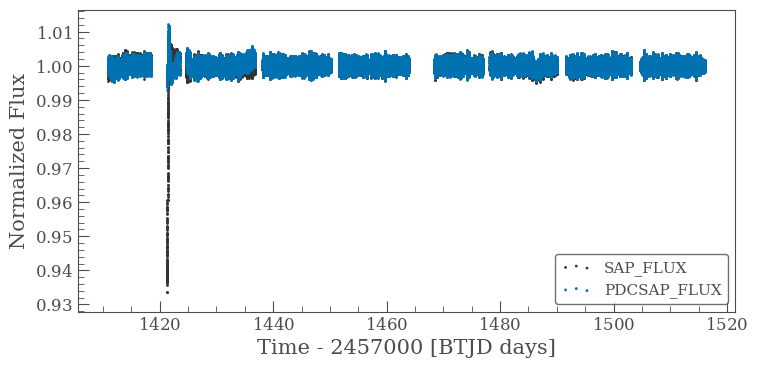

In [281]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

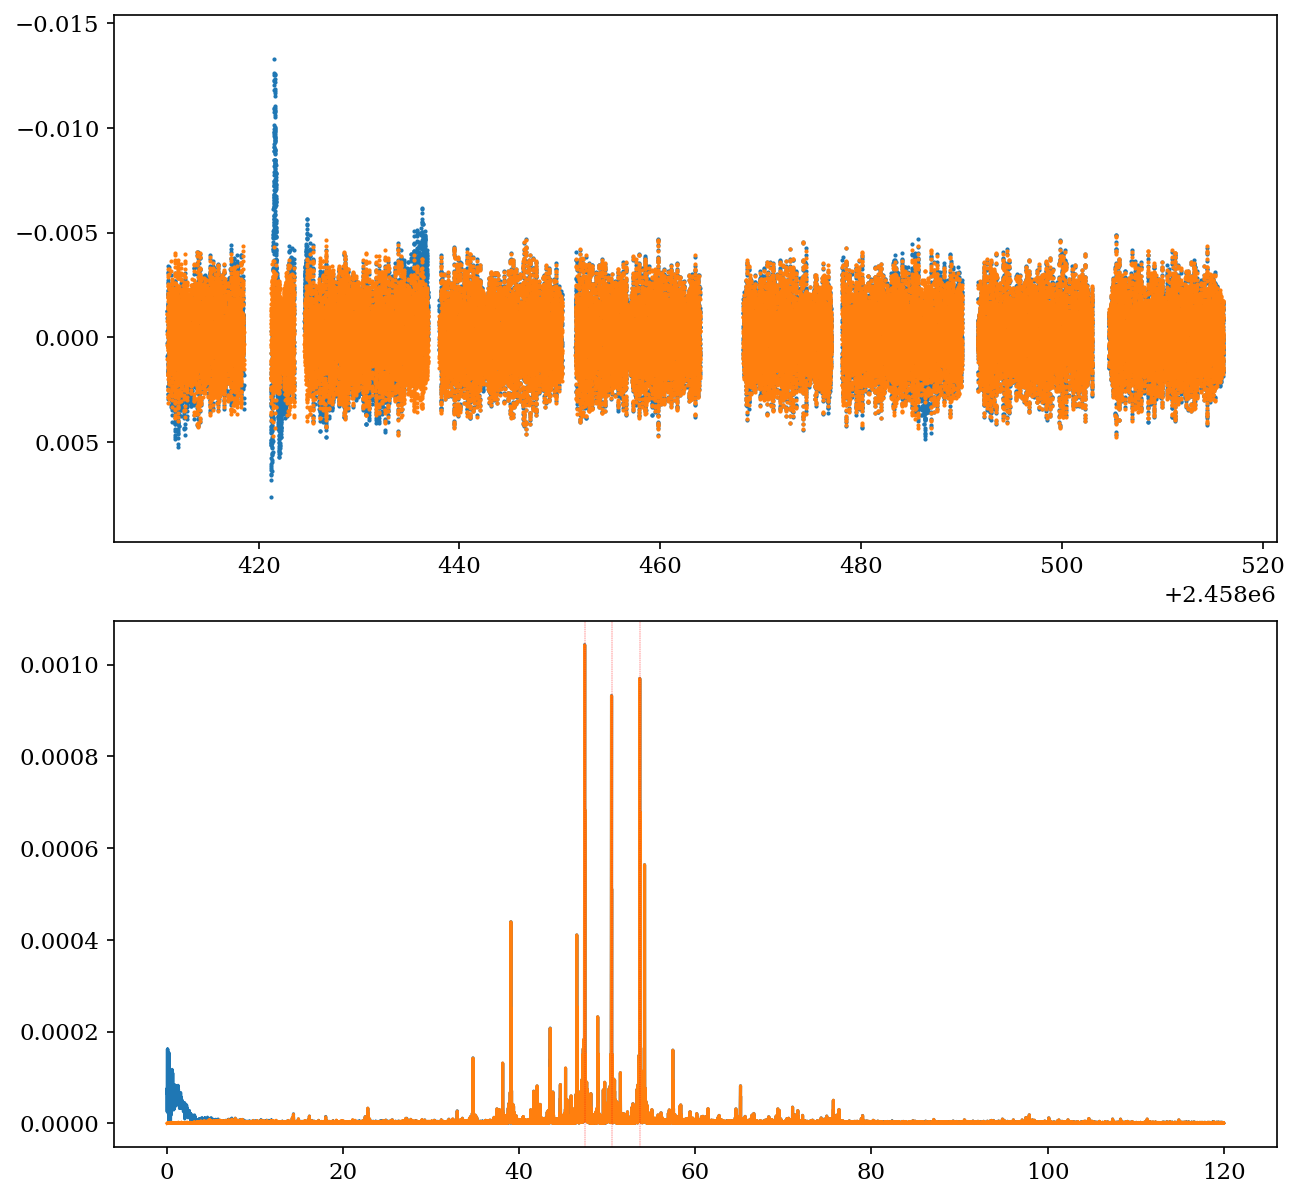

In [282]:
highpass_own = highpass(mags, 5, 50)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(times, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(times, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(times, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(times, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
mags_gaus = highpass_own[hpmax]

In [190]:
np.savetxt('TESS.txt', np.array([times, mags_gaus]).T)

In [83]:
t_2015 = 2457024.0-2457000.0
t_2016 = 2457389.0-2457000.0
t_2017 = 2457755.0-2457000.0
t_2018 = 2458120.0-2457000.0
t_2019 = 2458485.0-2457000.0

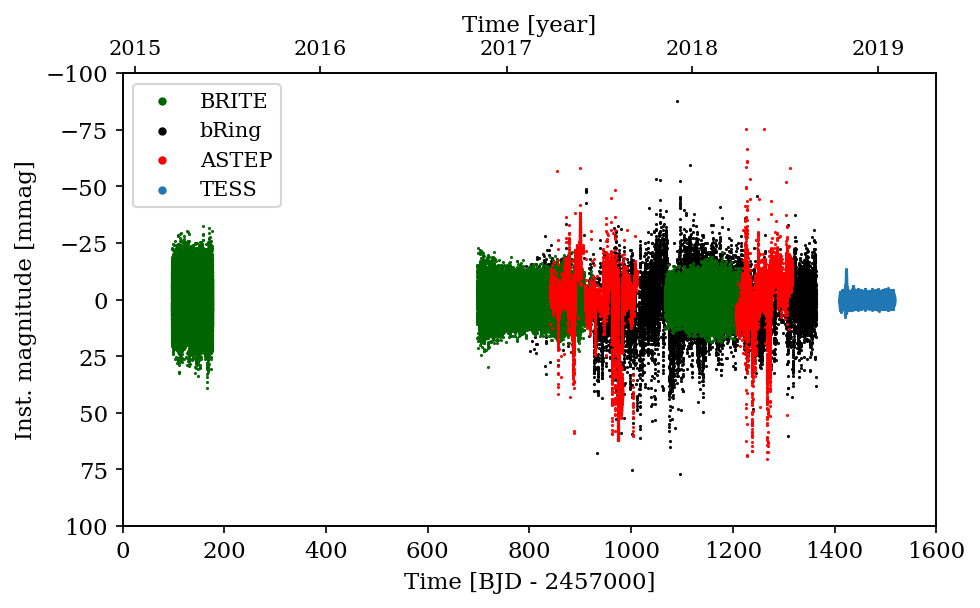

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

R = ax.scatter(t_bRing-2457000, m_bRing*1000, s=1, c='k', label = 'bRing', marker='.')

T = ax.scatter(times-2457000, mags*1000, s=1, label = 'TESS', marker='.')

t_combB = np.concatenate((tB15_BJD, tB16_BJD, tB17_BJD), axis=None)
m_combB = np.concatenate((mB15, mB16, mB17), axis=None)

B = ax.scatter(t_combB-2457000, m_combB*1000, marker='.', s=1, c = 'darkgreen', label = 'BRITE')

#ax.scatter(tB16_BJD, mB16/1000, marker='.', s=1)
#ax.scatter(tB17_BJD, mB17/1000, marker='.', s=1)

A = ax.scatter(t_ASTEP17-2457000, m_ASTEP17*1000, marker='.', s=1, c='r', label = 'ASTEP')
ax.scatter(t_ASTEP18-2457000, m_ASTEP18*1000, marker='.', s=1, c='r')

ax.invert_yaxis()

ax.set_xlim(0, 1600)
ax.set_ylim(100, -100)


ax.set_xlabel('Time [BJD - 2457000]')
ax.set_ylabel('Inst. magnitude [mmag]')



ax2 = ax.twiny()
ax2.tick_params(axis='x', rotation=0)


ax2.set_xticks([t_2015,t_2016,t_2017,t_2018,t_2019])

xmin1, xmax1 = ax.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2015', '2016', '2017', '2018', '2019'],fontsize=10)
ax2.set_xlabel('Time [year]')


lns = [B,R,A,T]
labs = [l.get_label() for l in lns]


ax.legend(lns, labs,markerscale=6, prop={'size': 10})

plt.savefig('total_lc.png', dpi = 550)

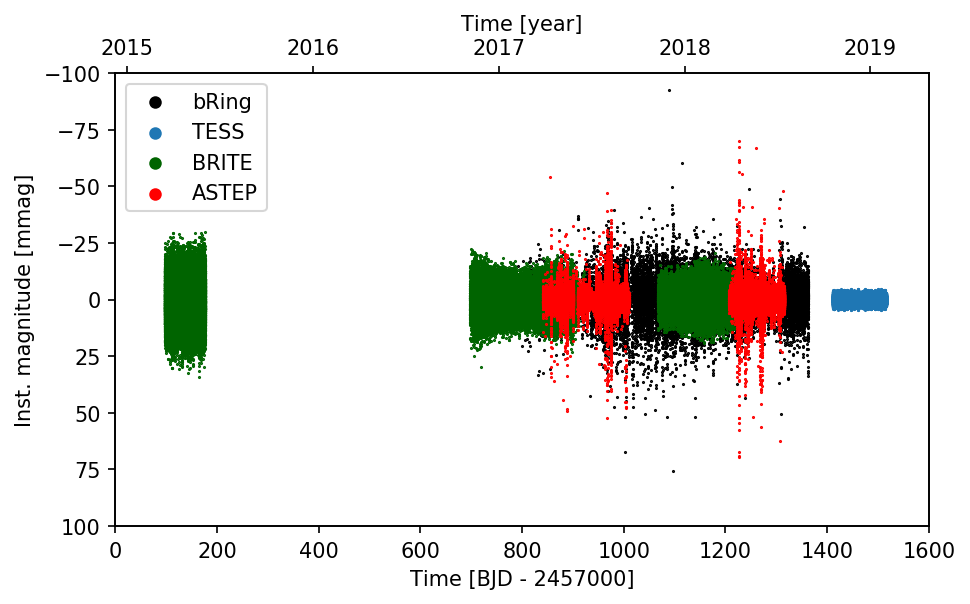

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.scatter(t_bRing-2457000, m_bRing_gaus*1000, s=1, c='k', label = 'bRing', marker='.')

ax.scatter(times-2457000, mags_gaus*1000, s=1, label = 'TESS', marker='.')

t_combB = np.concatenate((tB15_BJD, tB16_BJD, tB17_BJD), axis=None)
m_combB = np.concatenate((mB15_gaus/1000, mB16_gaus/1000, mB17_gaus/1000), axis=None)

ax.scatter(t_combB-2457000, m_combB*1000, marker='.', s=1, c = 'darkgreen', label = 'BRITE')

#ax.scatter(tB16_BJD, mB16/1000, marker='.', s=1)
#ax.scatter(tB17_BJD, mB17/1000, marker='.', s=1)

ax.scatter(t_ASTEP17-2457000, m_ASTEP17_gaus*1000, marker='.', s=1, c='r', label = 'ASTEP')
ax.scatter(t_ASTEP18-2457000, m_ASTEP18_gaus*1000, marker='.', s=1, c='r')

ax.invert_yaxis()

ax.set_xlim(0, 1600)
ax.set_ylim(100, -100)


ax.set_xlabel('Time [BJD - 2457000]')
ax.set_ylabel('Inst. magnitude [mmag]')



ax2 = ax.twiny()
ax2.tick_params(axis='x', rotation=0)


ax2.set_xticks([t_2015,t_2016,t_2017,t_2018,t_2019])

xmin1, xmax1 = ax.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2015', '2016', '2017', '2018', '2019'],fontsize=10)
ax2.set_xlabel('Time [year]')


ax.legend(markerscale=10, prop={'size': 10})

#plt.savefig('total_lc.png', dpi = 550)

In [40]:
times_all = [tB15_BJD, tB16_BJD, tB17_BJD, t_bRing[sort_idx_bRing], t_ASTEP17, t_ASTEP18, times]
magnitudes_all = [mB15_gaus/1000, mB16_gaus/1000, mB17_gaus/1000,m_bRing_gaus[sort_idx_bRing], m_ASTEP17_gaus, m_ASTEP18_gaus, mags_gaus]

In [41]:
bRing_len = len(t_bRing[sort_idx_bRing])

In [42]:
bRing_len

42021

In [43]:
t_bRing[sort_idx_bRing][:bRing_len//2]

array([2457787.31215396, 2457787.31215399, 2457787.31584746, ...,
       2458125.20610148, 2458125.20986253, 2458125.21337652])

In [44]:
t_bRing[sort_idx_bRing][bRing_len//2:]

array([2458125.21711859, 2458125.22071864, 2458125.22441853, ...,
       2458362.81290488, 2458362.81633077, 2458362.81855613])

In [45]:
times_all = [tB15_BJD, tB16_BJD, tB17_BJD, t_bRing[sort_idx_bRing][:bRing_len//2], t_bRing[sort_idx_bRing][bRing_len//2:], t_ASTEP17, t_ASTEP18, times]
magnitudes_all = [mB15_gaus/1000, mB16_gaus/1000, mB17_gaus/1000, m_bRing_gaus[sort_idx_bRing][:bRing_len//2], m_bRing_gaus[sort_idx_bRing][bRing_len//2:], m_ASTEP17_gaus, m_ASTEP18_gaus, mags_gaus]

In [46]:
times_all

[array([2457097.98961235, 2457097.98978935, 2457097.98996735, ...,
        2457176.31247614, 2457176.31259514, 2457176.31283414]),
 array([2457697.35263518, 2457697.35498618, 2457697.35522118, ...,
        2457921.92494084, 2457921.92517584, 2457921.92541084]),
 array([2458066.51742584, 2458066.51766084, 2458066.51789684, ...,
        2458233.85225077, 2458233.85248577, 2458233.85272077]),
 array([2457787.31215396, 2457787.31215399, 2457787.31584746, ...,
        2458125.20610148, 2458125.20986253, 2458125.21337652]),
 array([2458125.21711859, 2458125.22071864, 2458125.22441853, ...,
        2458362.81290488, 2458362.81633077, 2458362.81855613]),
 array([2457841.1423336, 2457841.144326 , 2457841.1453762, ...,
        2458011.1659874, 2458011.1669955, 2458011.168025 ]),
 array([2458206.1510377, 2458206.1530305, 2458206.1549982, ...,
        2458315.4373627, 2458315.4383451, 2458315.4396335]),
 array([2458410.90352425, 2458410.90491317, 2458410.90630209, ...,
        2458516.08417223, 24

In [47]:
times_all[7]

array([2458410.90352425, 2458410.90491317, 2458410.90630209, ...,
       2458516.08417223, 2458516.08556108, 2458516.08694993])

(2457000, 2458600)

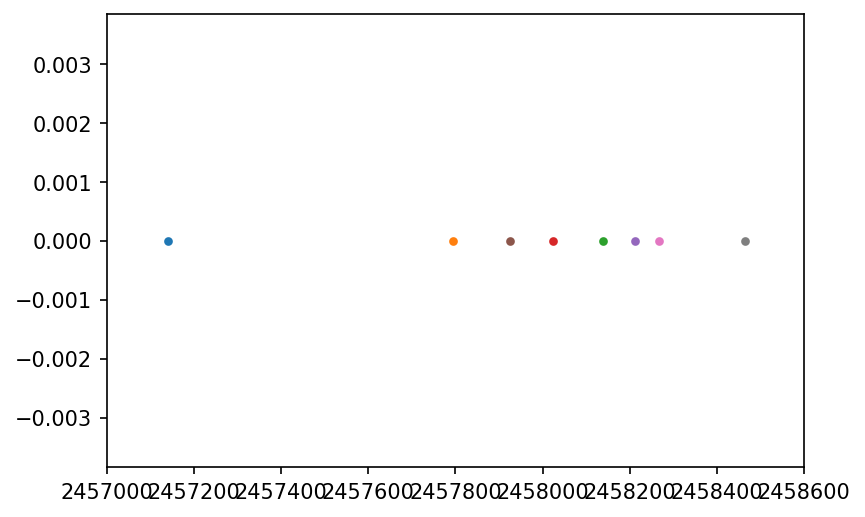

In [48]:
for i in range(8):
    plt.scatter(np.mean(times_all[i]), 0, s=10)
    plt.gca().invert_yaxis()
plt.xlim(0+2457000, 1600+2457000)
#plt.ylim(100/1000, -100/1000)

In [191]:
import lightkurve as lk

sr = lk.search_lightcurvefile('KIC 3437940')

In [192]:
sr

SearchResult containing 19 data products.

 target_name                      productFilename                                 description             distance
------------- ------------------------------------------------------- ----------------------------------- --------
kplr003437940                    kplr003437940-2009131105131_llc.fits  Lightcurve Long Cadence (CLC) - Q0      0.0
kplr003437940                    kplr003437940-2009166043257_llc.fits  Lightcurve Long Cadence (CLC) - Q1      0.0
kplr003437940                    kplr003437940-2009259160929_llc.fits  Lightcurve Long Cadence (CLC) - Q2      0.0
kplr003437940                    kplr003437940-2009350155506_llc.fits  Lightcurve Long Cadence (CLC) - Q3      0.0
kplr003437940                    kplr003437940-2010078095331_llc.fits  Lightcurve Long Cadence (CLC) - Q4      0.0
kplr003437940                    kplr003437940-2010174085026_llc.fits  Lightcurve Long Cadence (CLC) - Q5      0.0
kplr003437940                    kplr

In [193]:
sr = lk.search_lightcurvefile('KIC 3437940', mission='Kepler', cadence='short')

In [194]:
sr

SearchResult containing 1 data products.

 target_name            productFilename                        description             distance
------------- ------------------------------------ ----------------------------------- --------
kplr003437940 kplr003437940-2009322144938_slc.fits Lightcurve Short Cadence (CSC) - Q3      0.0

In [195]:
lc_sc = sr.download()

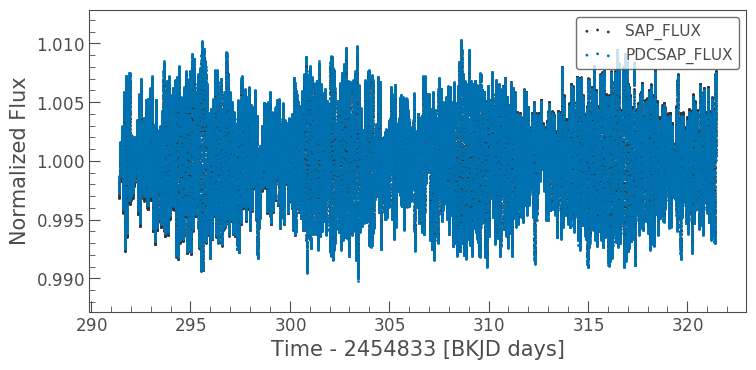

In [196]:
lc_sc.scatter()

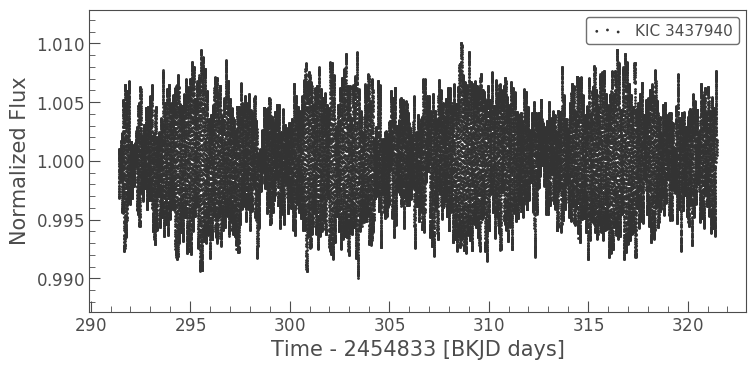

In [198]:
lc_sc.SAP_FLUX.scatter()

In [203]:
-2.5*np.log10(lc_sc.SAP_FLUX.normalize().flux)

array([ 0.00344155,  0.00336547,  0.00334632, ..., -0.00112571,
       -0.00085688, -0.00050932], dtype=float32)

In [208]:
np.savetxt('TIC3437940.txt', np.array([lc_sc.SAP_FLUX.time, -2.5*np.log10(lc_sc.SAP_FLUX.normalize().flux)]).T)

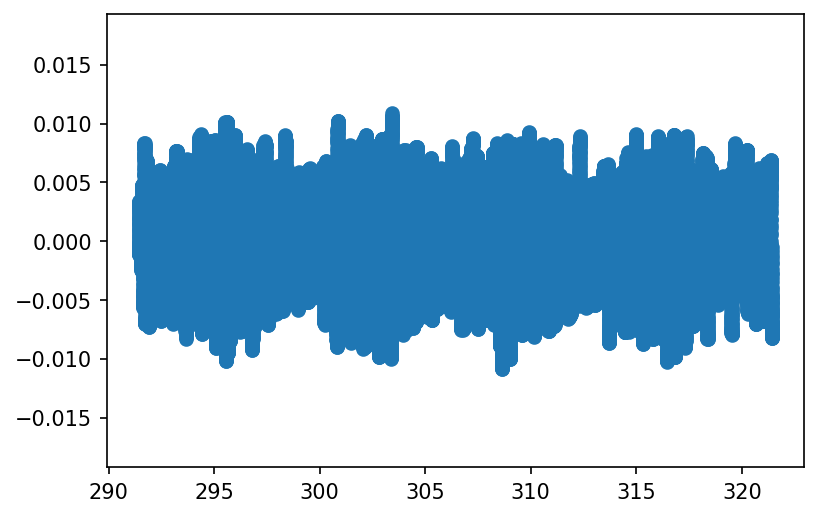

In [207]:
plt.scatter(lc_sc.SAP_FLUX.time, -2.5*np.log10(lc_sc.SAP_FLUX.normalize().flux))

In [213]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [227]:
lc_sc.SAP_FLUX.normalize().quality

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

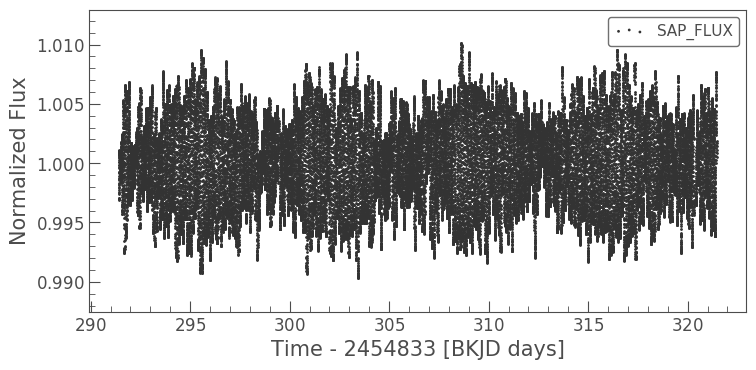

In [228]:
#Remove bad quality and nans
q0 = lc_sc.SAP_FLUX.normalize().quality == 0
lc0 = lc_sc.SAP_FLUX.normalize()[q0].remove_nans()
#Plot data
lc0.scatter(label = 'SAP_FLUX')

In [232]:
t_343 = lc0.time
m_343 = -2.5*np.log10(lc0.flux)

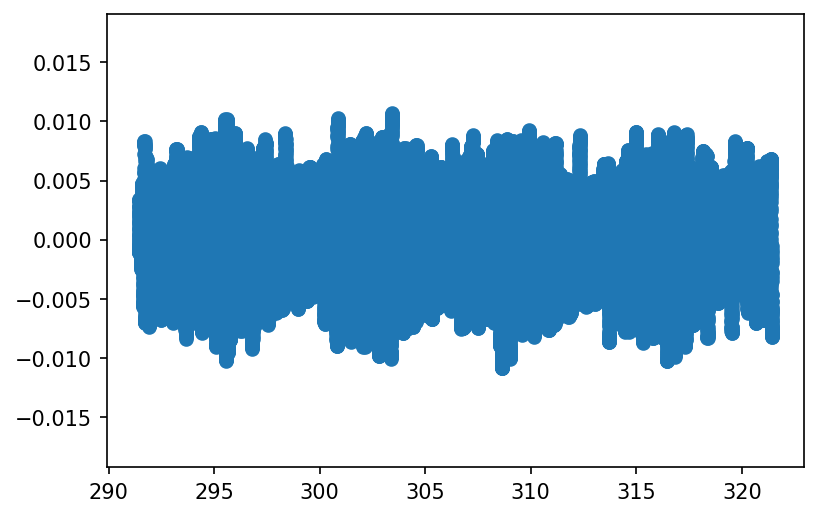

In [253]:
plt.scatter(t_343, m_343)

In [267]:
freq_343 = AS(t_343, m_343, 50)[0]
amp_343 = AS(t_343, m_343, 50)[1]

(0, 0.006)

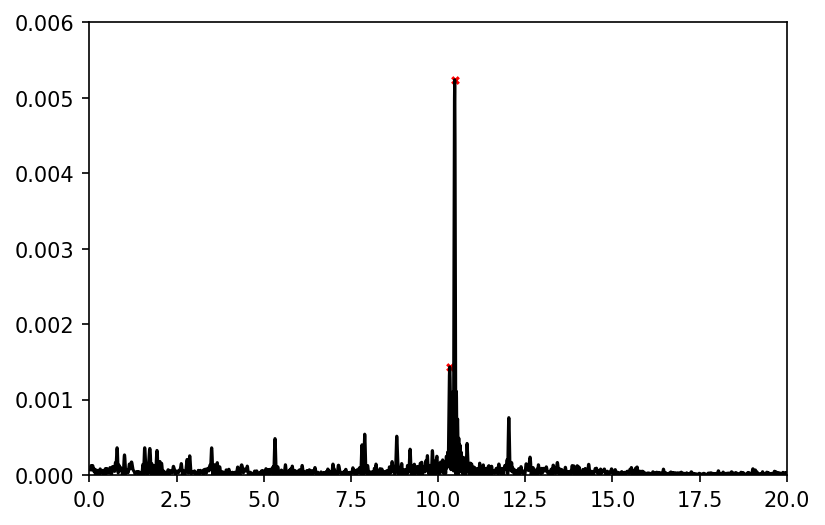

In [268]:
max_power = amp_343.max()
peaks, _ = find_peaks(amp_343, height=max_power*0.2, distance=200)
plt.scatter(freq_343[peaks], amp_343[peaks], marker="x", s=10, c='r')
plt.plot(freq_343, amp_343, c='k')
plt.xlim(0,20)
plt.ylim(0,0.006)

In [269]:
np.std(m_343)

0.004200534

In [270]:
amp_343[peaks]

array([0.00143522, 0.00523944])

In [283]:
def f_err_MO(times, mags, ampl):
    N = len(mags)
    timebase = max(times) - min(times)
    sigma_m = 0.00198#np.sqrt(np.mean((mags-np.mean(mags))**2))
    tmp = np.sqrt(6/N) * (1/(np.pi*timebase)) * sigma_m/ampl
    return tmp

def a_err_MO(mags):
    N = len(mags)
    sigma_m = np.std(mags)
    tmp = np.sqrt(2/N) * sigma_m
    return tmp

def p_err_MO(mags, ampl):
    N = len(mags)
    sigma_m = np.std(mags)
    tmp = np.sqrt(2/N) * sigma_m/ampl
    return tmp

In [9]:
import os 
#if you want to know current working dir
datadir = os.getcwd()

In [10]:
TESS = np.loadtxt(datadir + '/freqsTESS.per', usecols=(1,2,3))
B15 = np.loadtxt(datadir + '/freqsB15.per', usecols=(1,2,3))
B16 = np.loadtxt(datadir + '/freqsB16.per', usecols=(1,2,3))
B17 = np.loadtxt(datadir + '/freqsB17.per', usecols=(1,2,3))
A1 = np.loadtxt(datadir + '/freqsA1.per', usecols=(1,2,3))
A2 = np.loadtxt(datadir + '/freqsA2.per', usecols=(1,2,3))
A1_cut = np.loadtxt(datadir + '/freqsA1_cut.per', usecols=(1,2,3))
A2_cut = np.loadtxt(datadir + '/freqsA2_cut.per', usecols=(1,2,3))
R1 = np.loadtxt(datadir + '/freqsR1.per', usecols=(1,2,3))
R2 = np.loadtxt(datadir + '/freqsR2.per', usecols=(1,2,3))

In [11]:
TESSe = np.loadtxt(datadir + '/err_TESS_LS.err', usecols=(1,2,3), skiprows=21)
B15e = np.loadtxt(datadir + '/err_B15_LS.err', usecols=(1,2,3), skiprows=21)
B16e = np.loadtxt(datadir + '/err_B16_LS.err', usecols=(1,2,3), skiprows=21)
B17e = np.loadtxt(datadir + '/err_B17_LS.err', usecols=(1,2,3), skiprows=21)
A1e = np.loadtxt(datadir + '/err_A1_LS.err', usecols=(1,2,3), skiprows=21)
A2e = np.loadtxt(datadir + '/err_A2_LS.err', usecols=(1,2,3), skiprows=21)
A1e_cut = np.loadtxt(datadir + '/err_A1_LS_cut.err', usecols=(1,2,3), skiprows=21)
A2e_cut = np.loadtxt(datadir + '/err_A2_LS_cut.err', usecols=(1,2,3), skiprows=21)
R1e = np.loadtxt(datadir + '/err_R1_LS.err', usecols=(1,2,3), skiprows=13)
R2e = np.loadtxt(datadir + '/err_R2_LS.err', usecols=(1,2,3), skiprows=21)

In [12]:
full_mids = np.array([mt(tB15_BJD), mt(tB16_BJD), mt(tB17_BJD), mt(t_bRing[sort_idx_bRing][:bRing_len//2]), mt(t_bRing[sort_idx_bRing][bRing_len//2:]), mt(t_ASTEP17), mt(t_ASTEP18), mt(times), mt(t_ASTEP17), mt(t_ASTEP18)])

NameError: name 'mt' is not defined

In [ ]:
full_set = [B15, B16,B17, R1, R2,A1, A2,TESS,A1_cut, A2_cut]

In [ ]:
full_sete = [B15e, B16e,B17e, R1e, R2e,A1e, A2e,TESSe, A1e_cut, A2e_cut]

In [55]:
def sortfreq(lol):
    lol1 = list(lol)
    lol1.sort(key=lambda x: int(x[0]))
    return lol1

In [56]:
def mt(times):
    tmin = min(times)
    tmax = max(times)
    tmp = tmin + (tmax - tmin)/2
    return tmp

In [58]:
import matplotlib

In [ ]:
plt.rc('font', family='serif', size=11)
plt.tight_layout()

fix, ax = plt.subplots(4,1, figsize=(6,6.5), sharex=True)

x_offset = 2457000

for j in range(4):
    sel = [0,1,2]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='darkgreen', label='BRITE')


for j in range(4):
    sel = [3,4]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='k', label='bRing')
    
    
for j in range(4):
    sel = [5, 6]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='r', label='ASTEP')
    
    
for j in range(4):
    sel = [7]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='C0', label='TESS')

ax[0].legend(loc=1, prop={'size': 8.5})   
    
for j in range(4):
    ax[j].set_xlim(0, 1600)
    ax[j].axhline(full_set[7][j][0], c='r', alpha=0.4, ls='--')
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    ax[j].yaxis.set_major_formatter(y_formatter)
    ax[j].set_ylabel('Frequency [c/d]')
    
    
# for j in range(4):

#     sel = [8,9]
#     ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='C0')
#     ax[j].axhline(full_set[7][j][0], c='r', alpha=0.4, ls='--')
#     y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#     ax[j].yaxis.set_major_formatter(y_formatter)
#     ax[j].set_xlim(0, 1600)
    

ax2ymin, ax2ymax = ax[2].get_ylim()
ax[2].set_ylim(ax2ymin, ax2ymax + 0.00003)
ax3ymin, ax3ymax = ax[3].get_ylim()
ax[3].set_ylim(ax3ymin, ax3ymax + 0.0002)

ax[3].set_xlabel('Time [JD - 2457000]')


plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('freqsmod.png')

In [1]:
# Phases

In [13]:
TESS = np.loadtxt(datadir + '/freqsTESS.per', usecols=(1,2,3))
B15 = np.loadtxt(datadir + '/freqsB15.per', usecols=(1,2,3))
B16 = np.loadtxt(datadir + '/freqsB16.per', usecols=(1,2,3))
B17 = np.loadtxt(datadir + '/freqsB17.per', usecols=(1,2,3))
A1 = np.loadtxt(datadir + '/freqsA1.per', usecols=(1,2,3))
A2 = np.loadtxt(datadir + '/freqsA2.per', usecols=(1,2,3))
A1_cut = np.loadtxt(datadir + '/freqsA1_cut.per', usecols=(1,2,3))
A2_cut = np.loadtxt(datadir + '/freqsA2_cut.per', usecols=(1,2,3))
R1 = np.loadtxt(datadir + '/freqsR1.per', usecols=(1,2,3))
R2 = np.loadtxt(datadir + '/freqsR2.per', usecols=(1,2,3))

In [14]:
TESSe = np.loadtxt(datadir + '/err_TESS_LS.err', usecols=(1,2,3), skiprows=21)
B15e = np.loadtxt(datadir + '/err_B15_LS.err', usecols=(1,2,3), skiprows=21)
B16e = np.loadtxt(datadir + '/err_B16_LS.err', usecols=(1,2,3), skiprows=21)
B17e = np.loadtxt(datadir + '/err_B17_LS.err', usecols=(1,2,3), skiprows=21)
A1e = np.loadtxt(datadir + '/err_A1_LS.err', usecols=(1,2,3), skiprows=21)
A2e = np.loadtxt(datadir + '/err_A2_LS.err', usecols=(1,2,3), skiprows=21)
A1e_cut = np.loadtxt(datadir + '/err_A1_LS_cut.err', usecols=(1,2,3), skiprows=21)
A2e_cut = np.loadtxt(datadir + '/err_A2_LS_cut.err', usecols=(1,2,3), skiprows=21)
R1e = np.loadtxt(datadir + '/err_R1_LS.err', usecols=(1,2,3), skiprows=13)
R2e = np.loadtxt(datadir + '/err_R2_LS.err', usecols=(1,2,3), skiprows=21)

In [316]:
full_mids = np.array([mt(tB15_BJD), mt(tB16_BJD), mt(tB17_BJD), mt(t_bRing[sort_idx_bRing][:bRing_len//2]), mt(t_bRing[sort_idx_bRing][bRing_len//2:]), mt(t_ASTEP17), mt(t_ASTEP18), mt(times), mt(t_ASTEP17), mt(t_ASTEP18)])

In [53]:
full_set = [B15, B16,B17, R1, R2,A1, A2,TESS,A1_cut, A2_cut]

In [54]:
full_sete = [B15e, B16e,B17e, R1e, R2e,A1e, A2e,TESSe, A1e_cut, A2e_cut]

<Figure size 900x600 with 0 Axes>

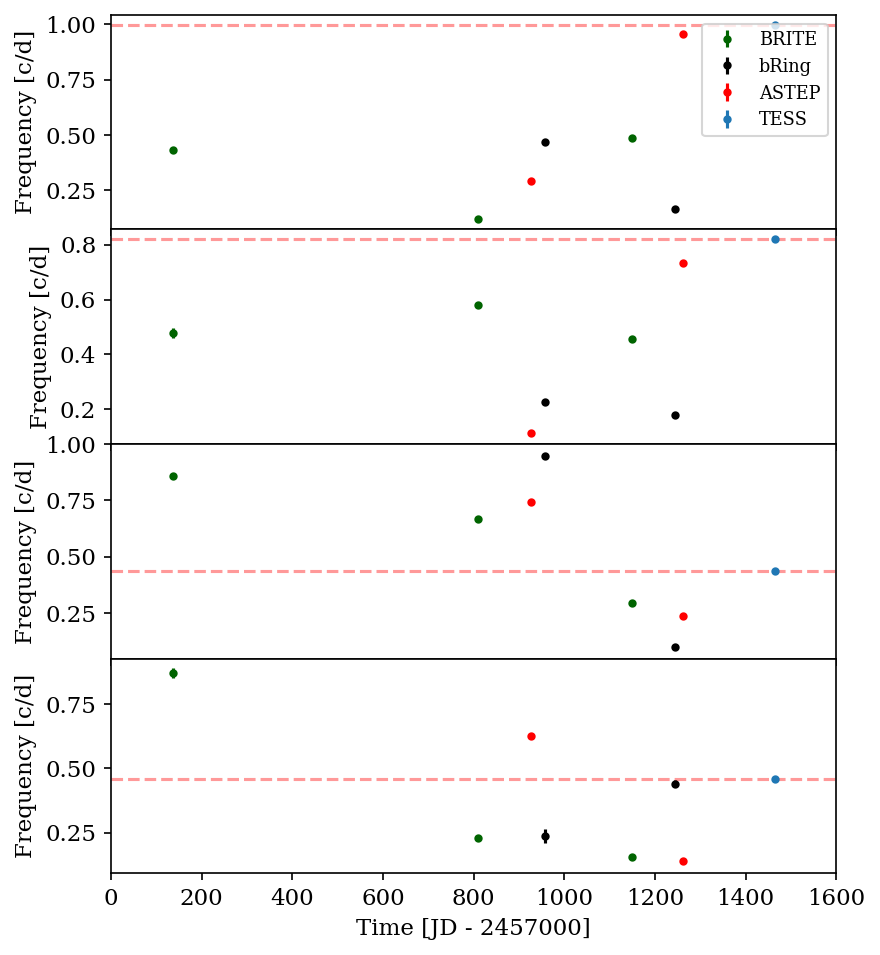

In [60]:
plt.rc('font', family='serif', size=11)
plt.tight_layout()

fix, ax = plt.subplots(4,1, figsize=(6,6.5), sharex=True)

x_offset = 2457000

for j in range(4):
    sel = [0,1,2]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2] for i in sel], fmt='.', c='darkgreen', label='BRITE')


for j in range(4):
    sel = [3,4]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2] for i in sel], fmt='.', c='k', label='bRing')
    
    
for j in range(4):
    sel = [5, 6]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2] for i in sel], fmt='.', c='r', label='ASTEP')
    
    
for j in range(4):
    sel = [7]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2] for i in sel], fmt='.', c='C0', label='TESS')

ax[0].legend(loc=1, prop={'size': 8.5})   
    
for j in range(4):
    ax[j].set_xlim(0, 1600)
    ax[j].axhline(full_set[7][j][2], c='r', alpha=0.4, ls='--')
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    ax[j].yaxis.set_major_formatter(y_formatter)
    ax[j].set_ylabel('Frequency [c/d]')
    
    
# for j in range(4):

#     sel = [8,9]
#     ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='C0')
#     ax[j].axhline(full_set[7][j][0], c='r', alpha=0.4, ls='--')
#     y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#     ax[j].yaxis.set_major_formatter(y_formatter)
#     ax[j].set_xlim(0, 1600)
    

ax2ymin, ax2ymax = ax[2].get_ylim()
ax[2].set_ylim(ax2ymin, ax2ymax + 0.00003)
ax3ymin, ax3ymax = ax[3].get_ylim()
ax[3].set_ylim(ax3ymin, ax3ymax + 0.0002)

ax[3].set_xlabel('Time [JD - 2457000]')


plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('freqsmod.png')

In [72]:
times_all = np.array([tB15_BJD, tB16_BJD, tB17_BJD, t_bRing[sort_idx_bRing][:bRing_len//2], t_bRing[sort_idx_bRing][bRing_len//2:], t_ASTEP17, t_ASTEP18, times])

In [73]:
mags_all = np.array([mB15_gaus, mB16_gaus, mB17_gaus, m_bRing_gaus[sort_idx_bRing][:bRing_len//2], m_bRing_gaus[sort_idx_bRing][bRing_len//2:], m_ASTEP17_gaus, m_ASTEP18_gaus, mags])

In [346]:
times_all

array([array([2457097.98961235, 2457097.98978935, 2457097.98996735, ...,
       2457176.31247614, 2457176.31259514, 2457176.31283414]),
       array([2457697.35263518, 2457697.35498618, 2457697.35522118, ...,
       2457921.92494084, 2457921.92517584, 2457921.92541084]),
       array([2458066.51742584, 2458066.51766084, 2458066.51789684, ...,
       2458233.85225077, 2458233.85248577, 2458233.85272077]),
       array([2457787.31215396, 2457787.31215399, 2457787.31584746, ...,
       2458125.20610148, 2458125.20986253, 2458125.21337652]),
       array([2458125.21711859, 2458125.22071864, 2458125.22441853, ...,
       2458362.81290488, 2458362.81633077, 2458362.81855613]),
       array([2457841.1423336, 2457841.144326 , 2457841.1453762, ...,
       2458011.1659874, 2458011.1669955, 2458011.168025 ]),
       array([2458206.1510377, 2458206.1530305, 2458206.1549982, ...,
       2458315.4373627, 2458315.4383451, 2458315.4396335]),
       array([2458410.90352425, 2458410.90491317, 2458410.90

In [358]:
times_all.tofile('yourfile.txt',sep=" ", format="%s")

In [360]:
[times_all[0], times_all[1]]

[array([2457097.98961235, 2457097.98978935, 2457097.98996735, ...,
        2457176.31247614, 2457176.31259514, 2457176.31283414]),
 array([2457697.35263518, 2457697.35498618, 2457697.35522118, ...,
        2457921.92494084, 2457921.92517584, 2457921.92541084])]

In [389]:
np.savetxt('times_all.txt', list(zip(times_all[0],times_all[1],times_all[2],times_all[3],times_all[4],times_all[5],times_all[6],times_all[7])), fmt='%s')

In [390]:
np.savetxt('mags_all.txt', list(zip(mags_all[0],mags_all[1],mags_all[2],mags_all[3],mags_all[4],mags_all[5],mags_all[6],mags_all[7])), fmt='%s')

In [372]:
times_all[0:2].T

array([array([2457097.98961235, 2457097.98978935, 2457097.98996735, ...,
       2457176.31247614, 2457176.31259514, 2457176.31283414]),
       array([2457697.35263518, 2457697.35498618, 2457697.35522118, ...,
       2457921.92494084, 2457921.92517584, 2457921.92541084])],
      dtype=object)

In [388]:
list(zip(times_all[0],times_all[1],times_all[2],times_all[3],times_all[4],times_all[5],times_all[6],times_all[7]))

[(2457097.98961235,
  2457697.35263518,
  2458066.51742584,
  2457787.3121539596,
  2458125.2171185934,
  2457841.1423336,
  2458206.1510377,
  2458410.903524246),
 (2457097.98978935,
  2457697.35498618,
  2458066.51766084,
  2457787.3121539867,
  2458125.220718642,
  2457841.144326,
  2458206.1530305,
  2458410.9049131675),
 (2457097.98996735,
  2457697.35522118,
  2458066.51789684,
  2457787.315847465,
  2458125.2244185256,
  2457841.1453762,
  2458206.1549982,
  2458410.9063020893),
 (2457097.99014435,
  2457697.35569218,
  2458066.51813184,
  2457787.3158474998,
  2458125.228201076,
  2457841.1475082,
  2458206.1559793,
  2458410.907691011),
 (2457097.99032135,
  2457697.35592718,
  2458066.51836684,
  2457787.3195409845,
  2458125.955882327,
  2457841.1487283,
  2458206.156968,
  2458410.9090799326),
 (2457097.99049935,
  2457697.35639718,
  2458066.51860184,
  2457787.319541016,
  2458125.9594503124,
  2457841.1497093,
  2458206.1589581,
  2458410.9104688545),
 (2457097.99067635,

In [385]:
list(zip(times_all[0:4]))

[(array([2457097.98961235, 2457097.98978935, 2457097.98996735, ...,
         2457176.31247614, 2457176.31259514, 2457176.31283414]),),
 (array([2457697.35263518, 2457697.35498618, 2457697.35522118, ...,
         2457921.92494084, 2457921.92517584, 2457921.92541084]),),
 (array([2458066.51742584, 2458066.51766084, 2458066.51789684, ...,
         2458233.85225077, 2458233.85248577, 2458233.85272077]),),
 (array([2457787.31215396, 2457787.31215399, 2457787.31584746, ...,
         2458125.20610148, 2458125.20986253, 2458125.21337652]),)]

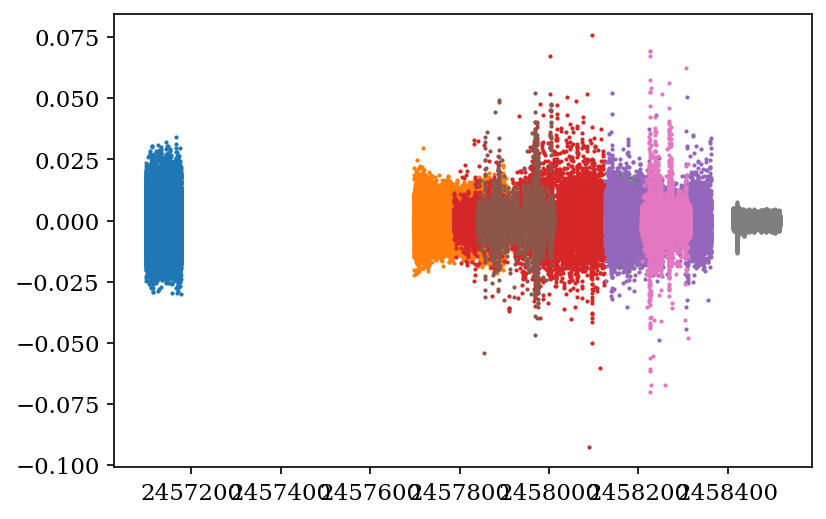

In [78]:
for i in range(8):
    plt.scatter(times_all[i], mags_all[i], s=1, c='C{0}'.format(i))

In [ ]:
ax.scatter(t_bRing-2457000, m_bRing_gaus*1000, s=1, c='k', label = 'bRing', marker='.')

ax.scatter(times-2457000, mags_gaus*1000, s=1, label = 'TESS', marker='.')

t_combB = np.concatenate((tB15_BJD, tB16_BJD, tB17_BJD), axis=None)
m_combB = np.concatenate((mB15_gaus/1000, mB16_gaus/1000, mB17_gaus/1000), axis=None)

ax.scatter(t_combB-2457000, m_combB*1000, marker='.', s=1, c = 'darkgreen', label = 'BRITE')

#ax.scatter(tB16_BJD, mB16/1000, marker='.', s=1)
#ax.scatter(tB17_BJD, mB17/1000, marker='.', s=1)

ax.scatter(t_ASTEP17-2457000, m_ASTEP17_gaus*1000, marker='.', s=1, c='r', label = 'ASTEP')
ax.scatter(t_ASTEP18-2457000, m_ASTEP18_gaus*1000, marker='.', s=1, c='r')

In [64]:
mB15_gaus

array([ 0.0108805 ,  0.00353349,  0.00787454, ..., -0.01171473,
        0.01634732,  0.01576932])

In [63]:
 m_ASTEP17_gaus

array([-0.00060937,  0.00054271,  0.00233341, ..., -0.00292269,
        0.00306632, -0.00223903])

In [81]:
full_set[0][0][0]

47.4393151158957

In [96]:
np.unwrap

<function numpy.unwrap(p, discont=3.141592653589793, axis=-1)>

In [109]:
min(times_all[0])

2457097.98961235

In [115]:
for i in range(8):
    print(dft_phase(times_all[i]-min(times_all[0]), mags_all[i], np.array([full_set[i][2][0]])))
    #print((2*np.pi*np.array([full_set[i][0][0]])*full_mids[i])%(2*np.pi))
    a = dft_phase(times_all[i], mags_all[i], np.array([full_set[i][0][0]]))[0]
    b = ((2*np.pi*np.array([full_set[i][0][0]])*full_mids[i])%(2*np.pi))[0]
    #print(np.unwrap([b-a]))

[6.18346644]
[3.9416133]
[5.30514168]
[5.33457473]
[4.94473938]
[4.74452688]
[3.72653846]
[3.29366408]


In [88]:
np.array([full_set[i][0][0]])

array([47.43905932])

In [106]:
for i in range(8):
    print((np.array([full_set[i][0][2]])+((2*np.pi*np.array([full_set[i][0][0]])*full_mids[i])%(2*np.pi)))%(2*np.pi))

[4.20070469]
[1.25840453]
[0.46566848]
[4.02522738]
[4.413505]
[2.97747671]
[5.72450594]
[4.64132793]


In [136]:
for i in range(8):
    print([full_set[i][0][2]])

[0.431712176369137]
[0.121372888036572]
[0.485736439179753]
[0.46716657777593]
[0.165537848476527]
[0.293097554211314]
[0.956511901623365]
[0.998337804169125]


In [141]:
[full_set[i][0][2]+0.3 for i in range(8)]

[0.731712176369137,
 0.42137288803657197,
 0.785736439179753,
 0.76716657777593,
 0.465537848476527,
 0.5930975542113139,
 1.256511901623365,
 1.298337804169125]

In [134]:
c = []
d = []
for i in range(8):
    aaa = full_mids[i]
    aa = times_all[i] - aaa
    a = times_all[i]
    b = mags_all[i]
    p1 = dft_phase(a,  b, [full_set[i][0][0]])
    p2 = dft_phase(aa, b, [full_set[i][0][0]])
    c.append(p1)
    d.append((p2 - 2*np.pi*full_set[i][0][0]*aaa)%(2*np.pi))

(0, 1)

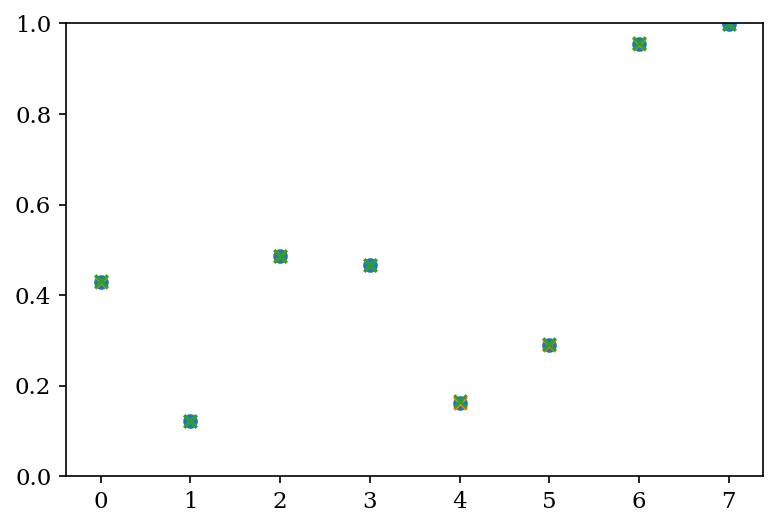

In [139]:
plt.scatter(range(8), np.array(c)/(2*np.pi))
plt.scatter(range(8), np.array(d)/(2*np.pi), marker = 'x')
plt.scatter(range(8), [full_set[i][0][2] for i in range(8)], marker = 'x')
plt.ylim(0, 1)

In [ ]:
plt.scatter(range(8), c)
plt.scatter(range(8), d, marker = 'x')
plt.ylim(0, 6.28)

In [118]:
full_set[0][0][0]

47.4393151158957

In [142]:
import timedelay

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [143]:
from timedelay import TimeDelay

array([array([2457097.98961235, 2457097.98978935, 2457097.98996735, ...,
       2457176.31247614, 2457176.31259514, 2457176.31283414]),
       array([2457697.35263518, 2457697.35498618, 2457697.35522118, ...,
       2457921.92494084, 2457921.92517584, 2457921.92541084]),
       array([2458066.51742584, 2458066.51766084, 2458066.51789684, ...,
       2458233.85225077, 2458233.85248577, 2458233.85272077]),
       array([2458410.90352425, 2458410.90491317, 2458410.90630209, ...,
       2458516.08417223, 2458516.08556108, 2458516.08694993])],
      dtype=object)

In [190]:
times_BT = times_all[np.array([0,1,2,7])]
mags_BT = mags_all[np.array([0,1,2,7])]

times_BT = [item for sublist in times_BT for item in sublist]
mags_BT = [item for sublist in mags_BT for item in sublist]

times_BT = np.array(times_BT)
mags_BT = np.array(mags_BT)



times_RT = times_all[np.array([3,4,7])]
mags_RT = mags_all[np.array([3,4,7])]

times_RT = [item for sublist in times_RT for item in sublist]
mags_RT = [item for sublist in mags_RT for item in sublist]

times_RT = np.array(times_RT)
mags_RT = np.array(mags_RT)


times_AT = times_all[np.array([5,6,7])]
mags_AT = mags_all[np.array([5,6,7])]

times_AT = [item for sublist in times_AT for item in sublist]
mags_AT = [item for sublist in mags_AT for item in sublist]

times_AT = np.array(times_AT)
mags_AT = np.array(mags_AT)

In [196]:
td = TimeDelay(times_AT, mags_AT, freqs=[full_set[7][0][0],full_set[7][1][0]])

Text(0, 0.5, 'Magnitude [mag]')

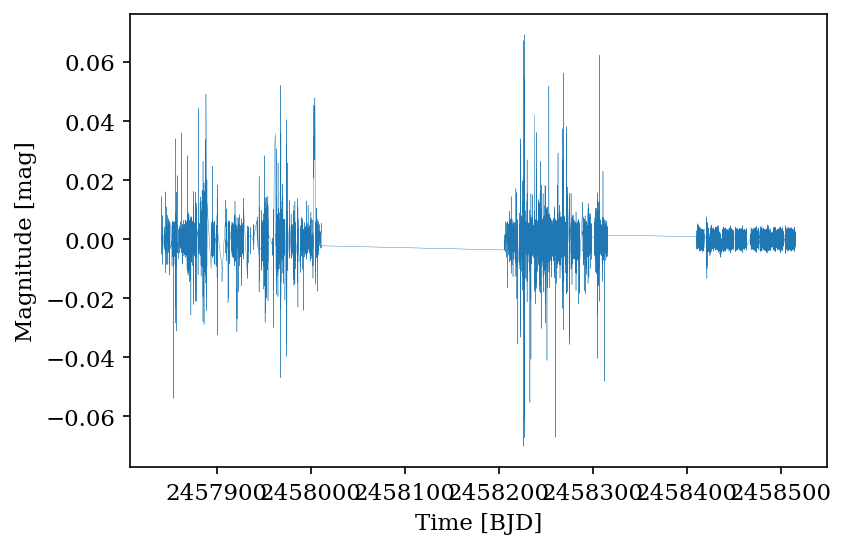

In [197]:
plt.plot(td.times, td.mags, linewidth=0.2)
plt.xlabel('Time [BJD]')
plt.ylabel('Magnitude [mag]')

100%|██████████| 128628/128628 [00:00<00:00, 745813.30it/s]


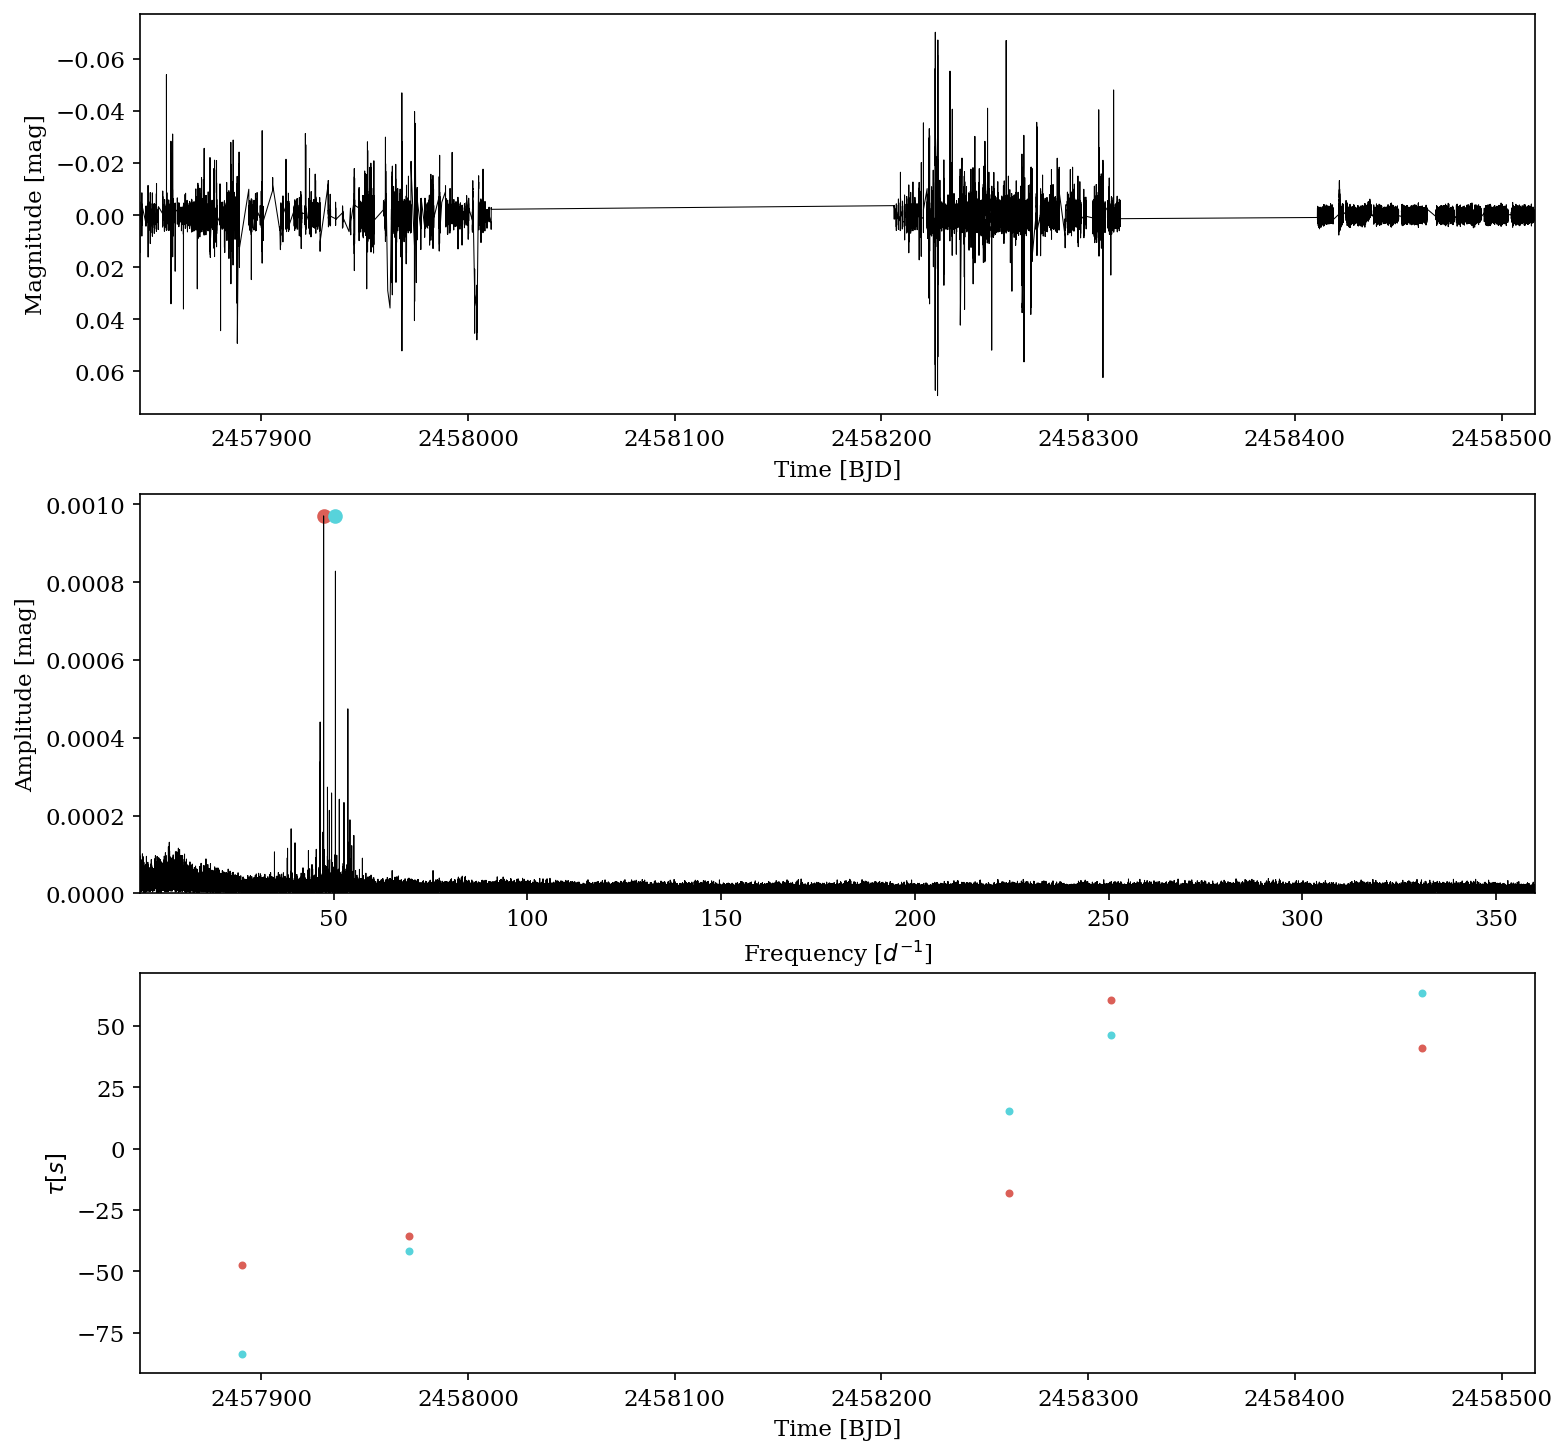

In [198]:
td.first_look(segment_size=100)

In [234]:
timebases = []
for i in range(8):
    timebases.append(max(times_all[i])-min(times_all[i]))
    
timebases = np.array(timebases)

In [261]:
segment_borders = np.array([0, len(tB15), len(tB15)+len(tB16),len(tB15)+len(tB16)+len(tB17), len(tB15)+len(tB16)+len(tB17)+len(times)])

In [267]:
segment_borders = np.array([0, len(times_all[3]), len(times_all[3])+len(times_all[4]), len(times_all[3])+len(times_all[4])+len(times)])

In [263]:
segment_borders = np.array([0, len(times_all[5]), len(times_all[5])+len(times_all[6]), len(times_all[5])+len(times_all[6])+len(times)])

In [268]:
from astropy.stats import LombScargle

freq = [full_set[7][0][0],full_set[7][1][0]]

time_0 = times_RT[0]
time_slice, mag_slice, phase = [], [], []
time_delays, time_midpoints = [], []

iteration = 0

for t, y, idx in zip(times_RT, mags_RT, range(len(times_RT))):
    time_slice.append(t)
    mag_slice.append(y)
    if idx == segment_borders[iteration+1]-1:
        print(idx)
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))
        # And the phases for each frequency
        phase.append(dft_phase(time_slice, mag_slice, freq))
        time_0 = t
        time_slice, mag_slice = [], []
        iteration += 1  
        
phase = np.array(phase).T
# Phase wrapping patch
for ph, f in zip(phase, freq):
    mean_phase = np.mean(ph)
    ph[np.where(ph - mean_phase > np.pi/2)] -= np.pi
    ph[np.where(ph - mean_phase < -np.pi/2)] += np.pi
    ph -= np.mean(ph)
#     ph = np.unwrap(ph)
#     ph -= np.mean(ph)

    td = ph / (2*np.pi*(f))
    time_delays.append(td*86400)

21009
42020
106629


In [269]:
time_midpoints

[2458024.242832022, 2458212.3137655878, 2458464.3601464923]

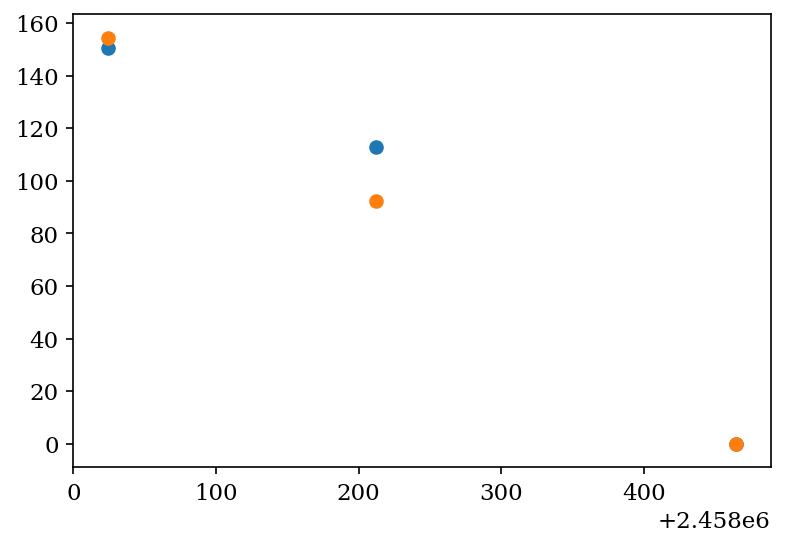

In [271]:
plt.scatter(time_midpoints, time_delays[0]-time_delays[0][2])
plt.scatter(time_midpoints, time_delays[1]-time_delays[1][2])

In [297]:
mid = min(times_all[0])+(max(times_all[7])-min(times_all[0]))/2

In [305]:
np.savetxt('BRITE15_mid.txt', np.array([tB15_BJD-mid, mB15_gaus]).T)
np.savetxt('BRITE16_mid.txt', np.array([tB16_BJD-mid, mB16_gaus]).T)
np.savetxt('BRITE17_mid.txt', np.array([tB17_BJD-mid, mB17_gaus]).T)

In [306]:
np.savetxt('bRing1_mid.txt', np.array([t_bRing[sort_idx_bRing][:bRing_len//2]-mid, m_bRing_gaus[sort_idx_bRing][:bRing_len//2]]).T)
np.savetxt('bRing2_mid.txt', np.array([t_bRing[sort_idx_bRing][bRing_len//2:]-mid, m_bRing_gaus[sort_idx_bRing][bRing_len//2:]]).T)

In [307]:
np.savetxt('ASTEP17_2048_mid.txt', np.array([t_ASTEP17-mid, m_ASTEP17_gaus]).T)
np.savetxt('ASTEP18_2048_mid.txt', np.array([t_ASTEP18-mid, m_ASTEP18_gaus]).T)

In [308]:
np.savetxt('TESS_mid.txt', np.array([times-mid, mags_gaus]).T)

In [304]:
t_bRing[sort_idx_bRing][:bRing_len//2]-mid

array([-19.72612718, -19.72612716, -19.72243368, ..., 318.16782034,
       318.17158138, 318.17509537])

In [309]:
resT = 0.000624325904
resB15 = 0.00822189421
resB16 = 0.00529456898
resB17 = 0.00465416046
resA1 = 0.00376961612
resA2 = 0.00393032297
resR1 = 0.00702802937
resR1 = 0.00601361301

In [324]:
TESS = np.loadtxt(datadir + '/mid/solT.per', usecols=(1,2,3))
B15 = np.loadtxt(datadir + '/mid/solB15.per', usecols=(1,2,3))
B16 = np.loadtxt(datadir + '/mid/solB16.per', usecols=(1,2,3))
B17 = np.loadtxt(datadir + '/mid/solB17.per', usecols=(1,2,3))
A1 = np.loadtxt(datadir + '/mid/solA1.per', usecols=(1,2,3))
A2 = np.loadtxt(datadir + '/mid/solA2.per', usecols=(1,2,3))
R1 = np.loadtxt(datadir + '/mid/solR1.per', usecols=(1,2,3))
R2 = np.loadtxt(datadir + '/mid/solR2.per', usecols=(1,2,3))

In [325]:
TESSe = np.loadtxt(datadir + '/mid/errT.err', usecols=(1,2,3), skiprows=21)
B15e = np.loadtxt(datadir + '/mid/errB15.err', usecols=(1,2,3), skiprows=21)
B16e = np.loadtxt(datadir + '/mid/errB16.err', usecols=(1,2,3), skiprows=21)
B17e = np.loadtxt(datadir + '/mid/errB17.err', usecols=(1,2,3), skiprows=21)
A1e = np.loadtxt(datadir + '/mid/errA1.err', usecols=(1,2,3), skiprows=21)
A2e = np.loadtxt(datadir + '/mid/errA2.err', usecols=(1,2,3), skiprows=21)
R1e = np.loadtxt(datadir + '/mid/errR1.err', usecols=(1,2,3), skiprows=21)
R2e = np.loadtxt(datadir + '/mid/errR2.err', usecols=(1,2,3), skiprows=21)

In [326]:
full_set = [B15, B16,B17, R1, R2,A1, A2,TESS]
full_sete = [B15e, B16e,B17e, R1e, R2e,A1e, A2e,TESSe]

<Figure size 900x600 with 0 Axes>

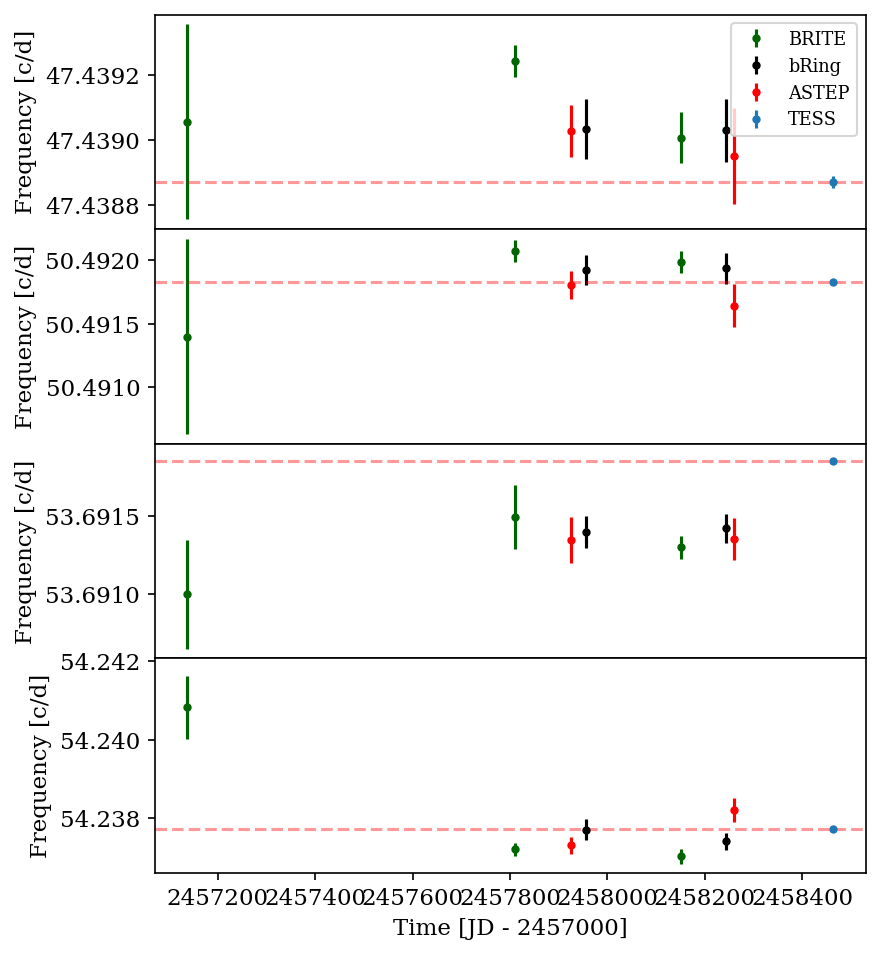

In [327]:
plt.rc('font', family='serif', size=11)
plt.tight_layout()

fix, ax = plt.subplots(4,1, figsize=(6,6.5), sharex=True)

x_offset = 0

for j in range(4):
    sel = [0,1,2]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='darkgreen', label='BRITE')


for j in range(4):
    sel = [3,4]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='k', label='bRing')
    
    
for j in range(4):
    sel = [5, 6]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='r', label='ASTEP')
    
    
for j in range(4):
    sel = [7]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='C0', label='TESS')

ax[0].legend(loc=1, prop={'size': 8.5})   
    
for j in range(4):
    #ax[j].set_xlim(0, 1600)
    ax[j].axhline(full_set[7][j][0], c='r', alpha=0.4, ls='--')
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    ax[j].yaxis.set_major_formatter(y_formatter)
    ax[j].set_ylabel('Frequency [c/d]')
    
    
# for j in range(4):

#     sel = [8,9]
#     ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='C0')
#     ax[j].axhline(full_set[7][j][0], c='r', alpha=0.4, ls='--')
#     y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#     ax[j].yaxis.set_major_formatter(y_formatter)
#     ax[j].set_xlim(0, 1600)
    

ax2ymin, ax2ymax = ax[2].get_ylim()
ax[2].set_ylim(ax2ymin, ax2ymax + 0.00003)
ax3ymin, ax3ymax = ax[3].get_ylim()
ax[3].set_ylim(ax3ymin, ax3ymax + 0.0002)

ax[3].set_xlabel('Time [JD - 2457000]')


plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('freqsmod.png')

<Figure size 900x600 with 0 Axes>

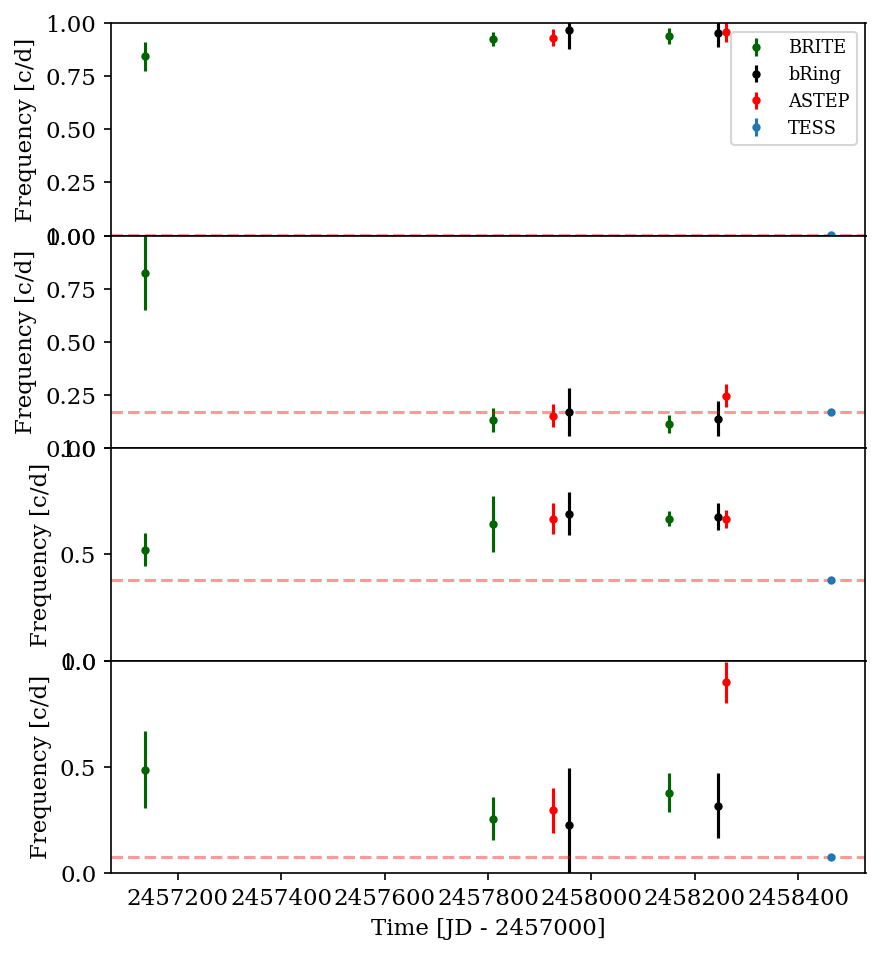

In [332]:
plt.rc('font', family='serif', size=11)
plt.tight_layout()

fix, ax = plt.subplots(4,1, figsize=(6,6.5), sharex=True)

x_offset = 0

for j in range(4):
    sel = [0,1,2]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2]*10 for i in sel], fmt='.', c='darkgreen', label='BRITE')


for j in range(4):
    sel = [3,4]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2]*10 for i in sel], fmt='.', c='k', label='bRing')
    
    
for j in range(4):
    sel = [5, 6]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2]*10 for i in sel], fmt='.', c='r', label='ASTEP')
    
    
for j in range(4):
    sel = [7]
    ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][2] for i in sel], yerr=[full_sete[i][j][2]*10 for i in sel], fmt='.', c='C0', label='TESS')

ax[0].legend(loc=1, prop={'size': 8.5})   
    
for j in range(4):
    ax[j].set_ylim(0, 1)
    ax[j].axhline(full_set[7][j][2], c='r', alpha=0.4, ls='--')
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    ax[j].yaxis.set_major_formatter(y_formatter)
    ax[j].set_ylabel('Frequency [c/d]')
    
    
# for j in range(4):

#     sel = [8,9]
#     ax[j].errorbar(full_mids[np.array(sel)] - x_offset, [full_set[i][j][0] for i in sel], yerr=[full_sete[i][j][0] for i in sel], fmt='.', c='C0')
#     ax[j].axhline(full_set[7][j][0], c='r', alpha=0.4, ls='--')
#     y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#     ax[j].yaxis.set_major_formatter(y_formatter)
#     ax[j].set_xlim(0, 1600)
    

ax2ymin, ax2ymax = ax[2].get_ylim()
ax[2].set_ylim(ax2ymin, ax2ymax + 0.00003)
ax3ymin, ax3ymax = ax[3].get_ylim()
ax[3].set_ylim(ax3ymin, ax3ymax + 0.0002)

ax[3].set_xlabel('Time [JD - 2457000]')


plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


#plt.savefig('freqsmod.png')